In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import scipy
from sklearn.neighbors import LocalOutlierFactor  # pip install scikit-learn
%matplotlib inline

In [2]:
df = pd.read_pickle("../../data/interim/01_data_processed.pkl")

In [3]:
outlier_columns= list(df.columns[:6])

In [4]:
outlier_columns

['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']

In [5]:
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (20, 5)
plt.rcParams["figure.dpi"] = 100

<AxesSubplot: title={'center': 'acc_x'}, xlabel='[label]'>

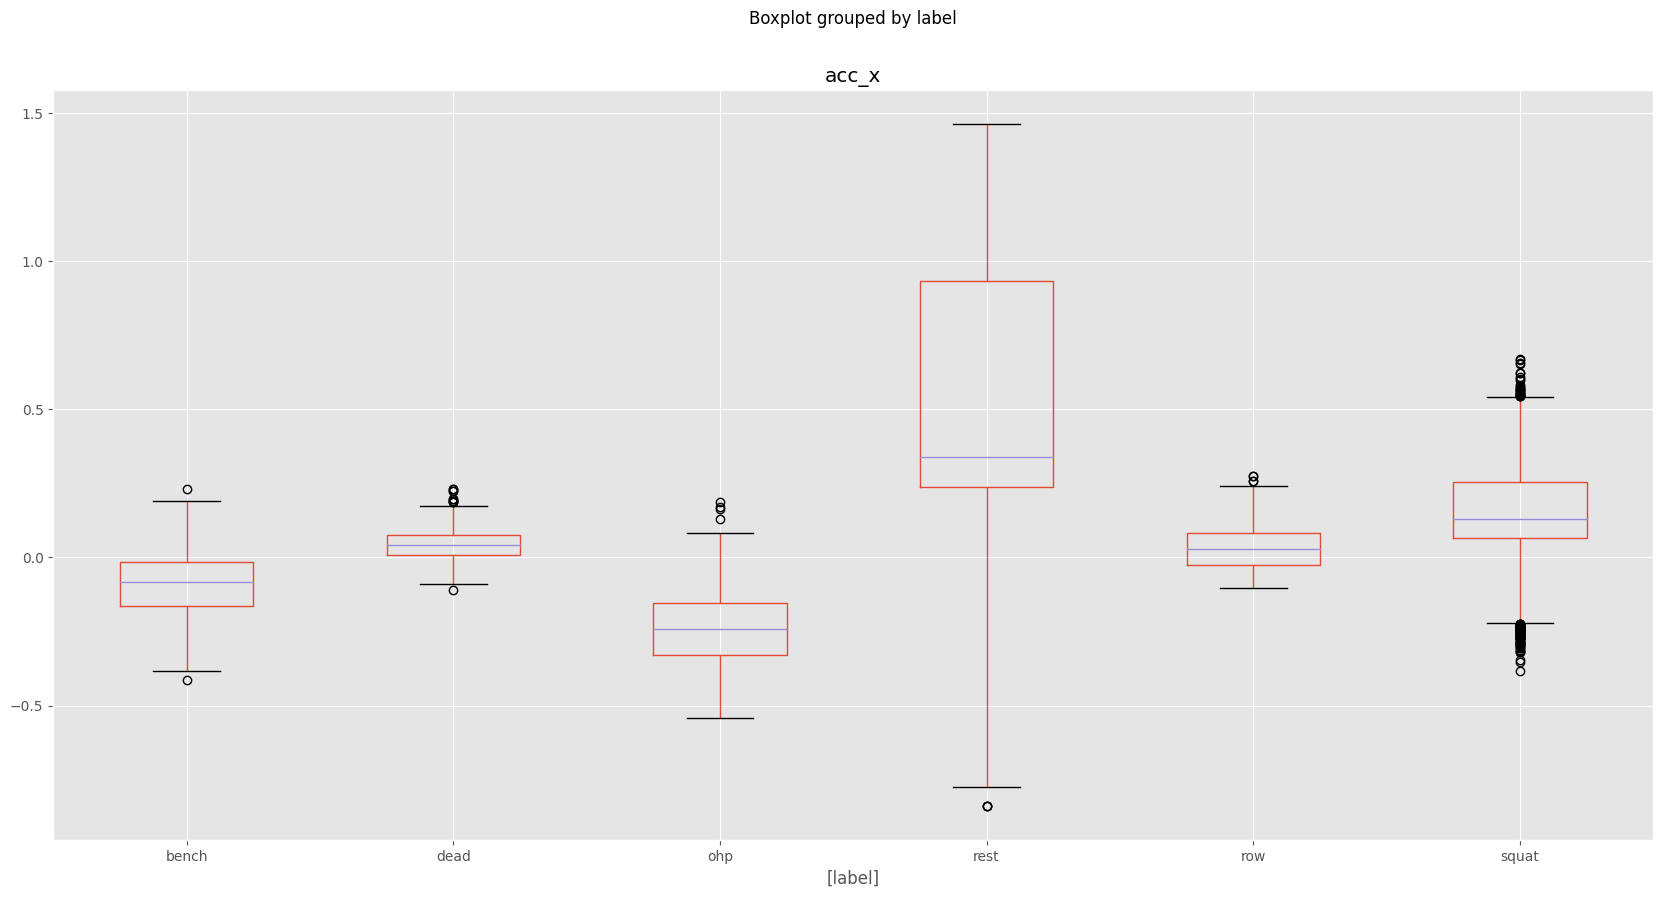

In [6]:
df[["acc_x", "label"]].boxplot(by="label", figsize=(20, 10))

array([<AxesSubplot: title={'center': 'acc_x'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'acc_y'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'acc_z'}, xlabel='[label]'>],
      dtype=object)

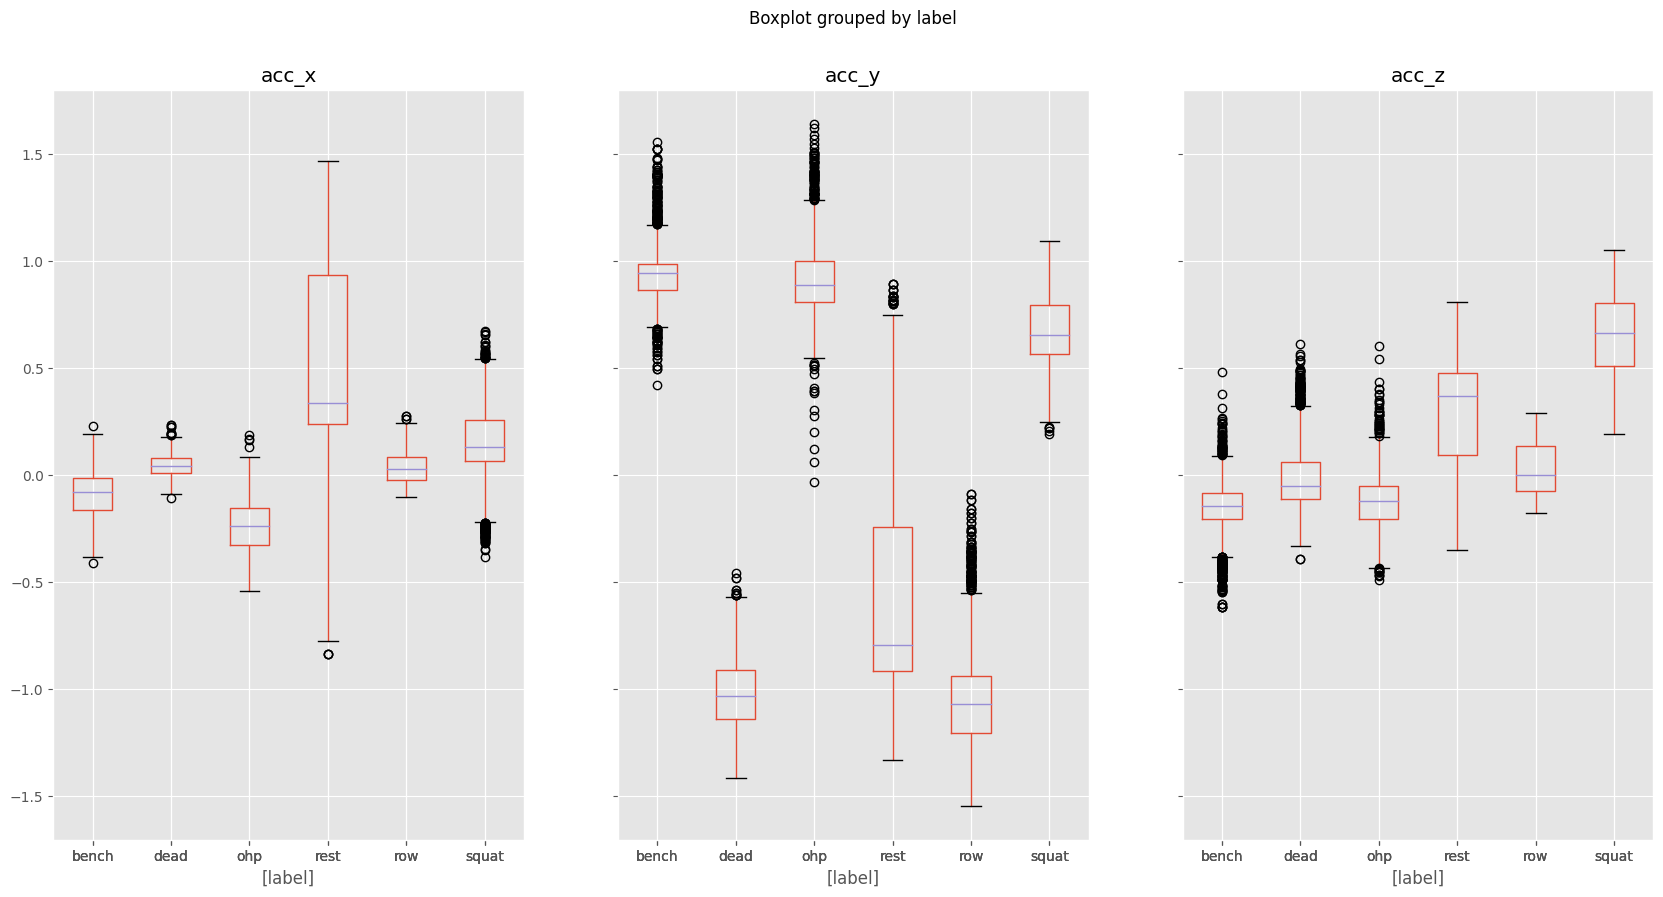

In [7]:
df[outlier_columns[:3] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1,3))

array([<AxesSubplot: title={'center': 'gyr_x'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'gyr_y'}, xlabel='[label]'>,
       <AxesSubplot: title={'center': 'gyr_z'}, xlabel='[label]'>],
      dtype=object)

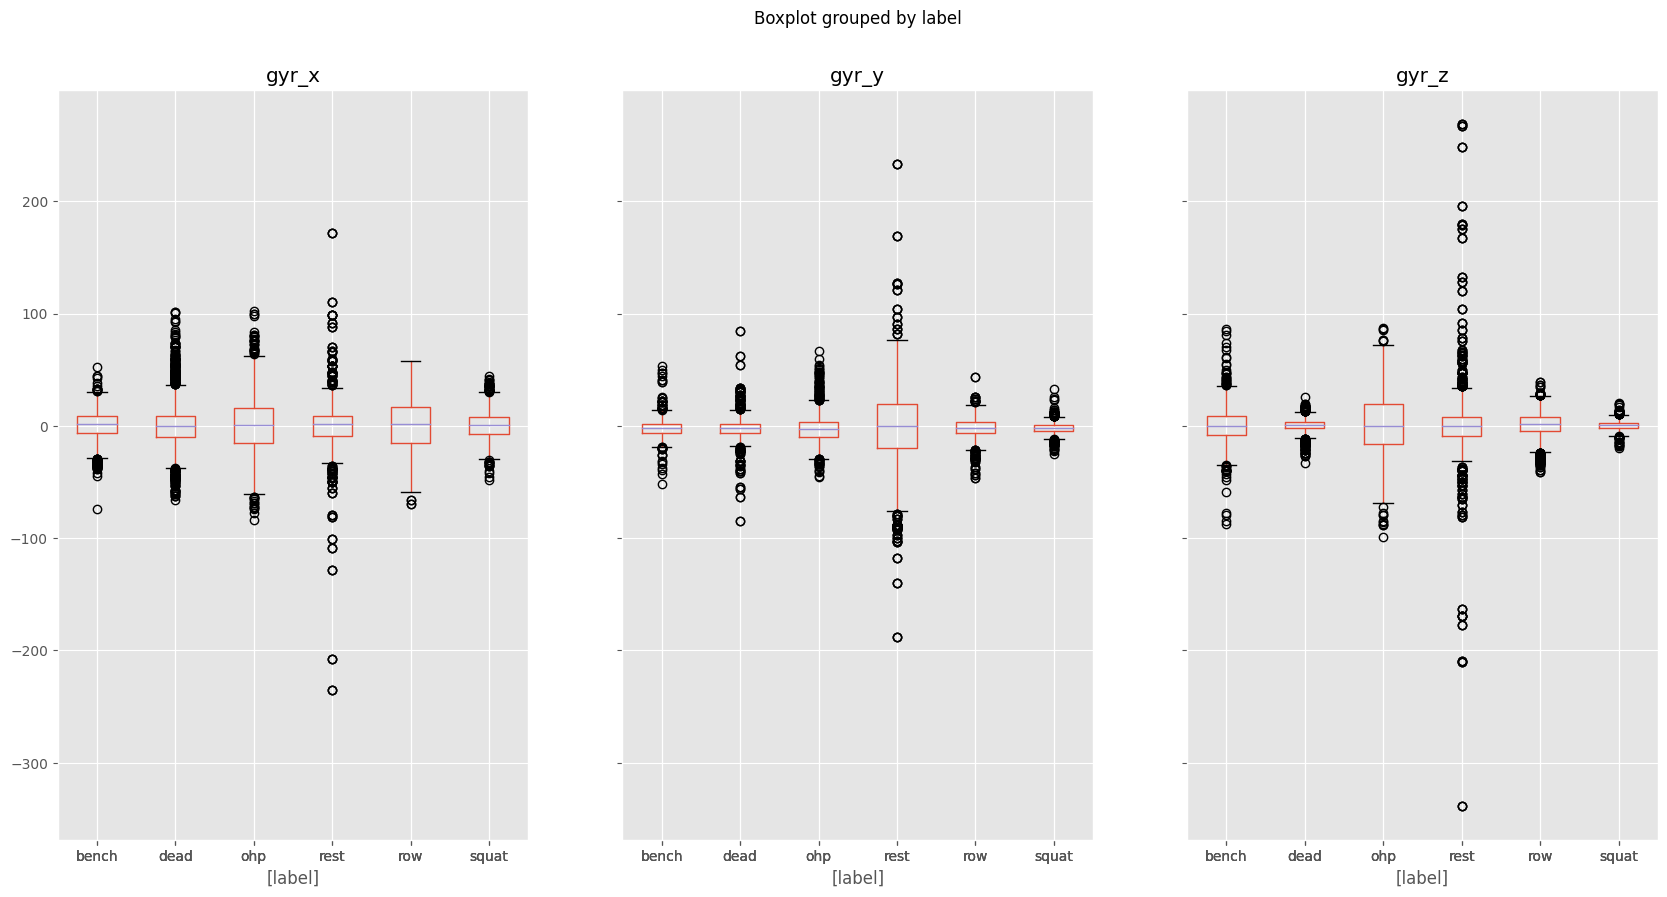

In [8]:
df[outlier_columns[3:] + ["label"]].boxplot(by="label", figsize=(20, 10), layout=(1,3))

In [9]:
df[outlier_columns[:3] + ["label"]]

acc_x     acc_y     acc_z  label
epoch (ms)                                                  
2019-01-11 15:08:05.200  0.013500  0.977000 -0.071000  bench
2019-01-11 15:08:05.400 -0.001500  0.970500 -0.079500  bench
2019-01-11 15:08:05.600  0.001333  0.971667 -0.064333  bench
2019-01-11 15:08:05.800 -0.024000  0.957000 -0.073500  bench
2019-01-11 15:08:06.000 -0.028000  0.957667 -0.115000  bench
...                           ...       ...       ...    ...
2019-01-20 17:33:27.000 -0.048000 -1.041500 -0.076500    row
2019-01-20 17:33:27.200 -0.037000 -1.030333 -0.053333    row
2019-01-20 17:33:27.400 -0.060000 -1.031000 -0.082000    row
2019-01-20 17:33:27.600 -0.038667 -1.025667 -0.044667    row
2019-01-20 17:33:27.800 -0.044000 -1.034000 -0.059000    row

[9009 rows x 4 columns]

In [12]:
def plot_binary_outliers(dataset, col, outlier_col, reset_index):
    """ Plot outliers in case of a binary outlier score. Here, the col specifies the real data
    column and outlier_col the columns with a binary value (outlier or not).

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): Column that you want to plot
        outlier_col (string): Outlier column marked with true/false
        reset_index (bool): whether to reset the index for plotting
    """

    # Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/util/VisualizeDataset.py

    dataset = dataset.dropna(axis=0, subset=[col, outlier_col])
    dataset[outlier_col] = dataset[outlier_col].astype("bool")

    if reset_index:
        dataset = dataset.reset_index()

    fig, ax = plt.subplots()

    plt.xlabel("samples")
    plt.ylabel("value")

    # Plot non outliers in default color
    ax.plot(
        dataset.index[~dataset[outlier_col]],
        dataset[col][~dataset[outlier_col]],
        "b+",
    )
    # Plot data points that are outliers in red
    ax.plot(
        dataset.index[dataset[outlier_col]],
        dataset[col][dataset[outlier_col]],
        "r+",
    )

    plt.legend(
        ["no outlier " + col,"outlier " + col],
        loc="upper center",
        ncol=2,
        fancybox=True,
        shadow=True,
    )
    plt.show()

# --------------------------------------------------------------
# Interquartile range (distribution based)
# --------------------------------------------------------------

# Insert IQR function

def mark_outliers_iqr(dataset, col):
    """Function to mark values as outliers using the IQR method.

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()

    Q1 = dataset[col].quantile(0.25)
    Q3 = dataset[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    dataset[col + "_outlier"] = (dataset[col] < lower_bound) | (
        dataset[col] > upper_bound
    )

    return dataset

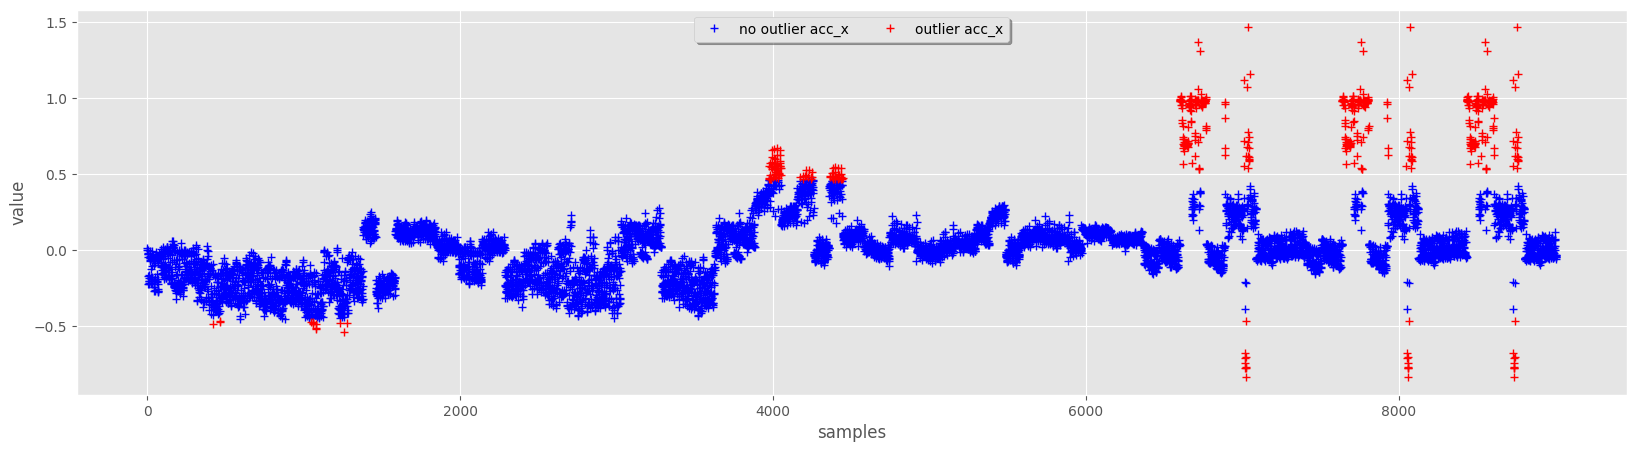

In [13]:
col = "acc_x"
dataset = mark_outliers_iqr(df, col)
plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

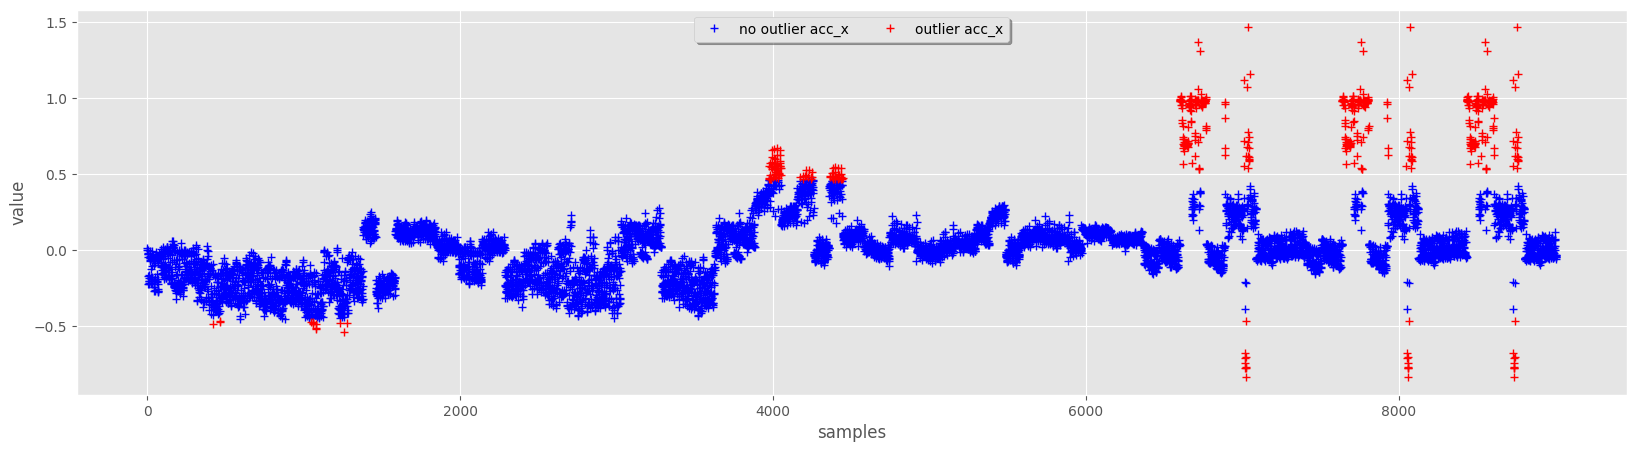

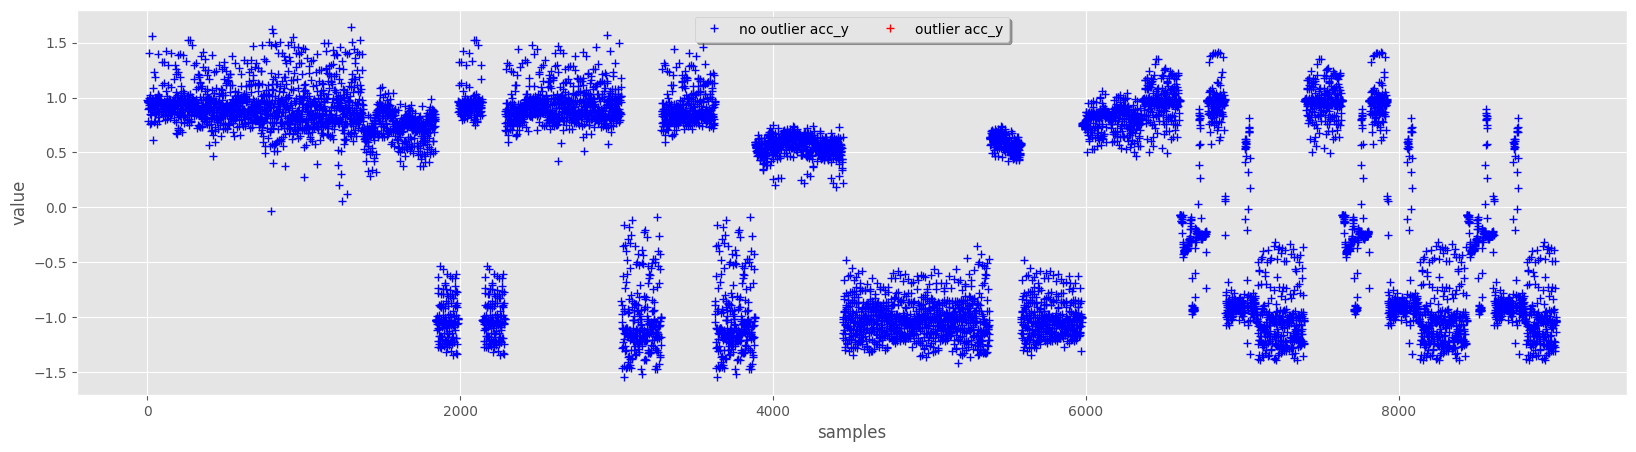

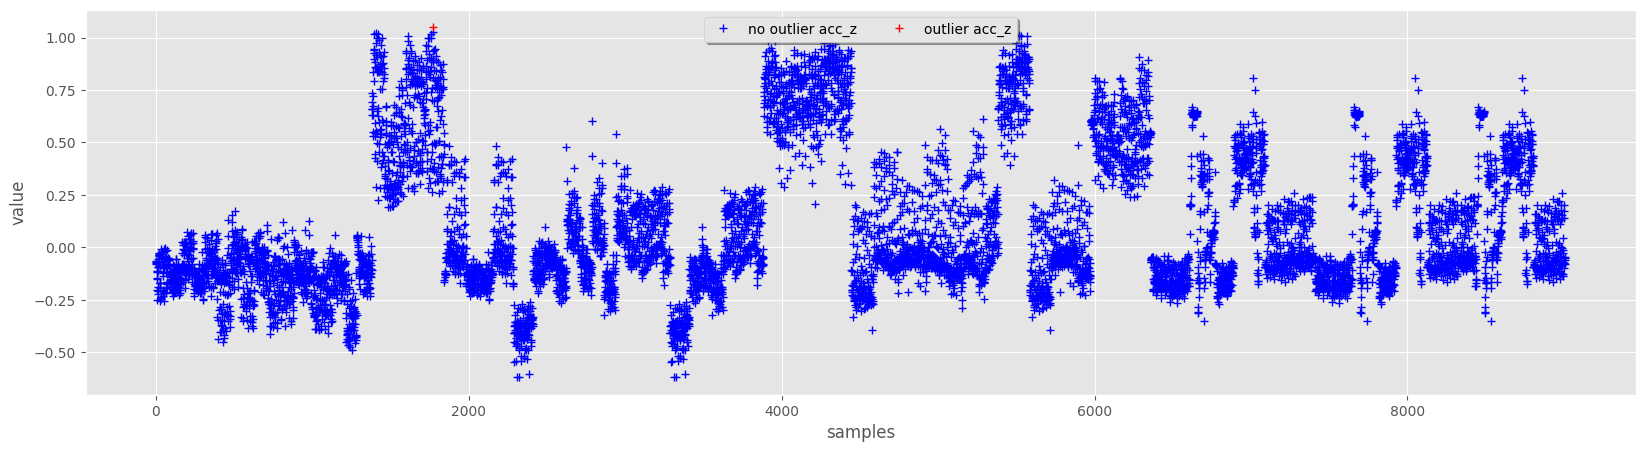

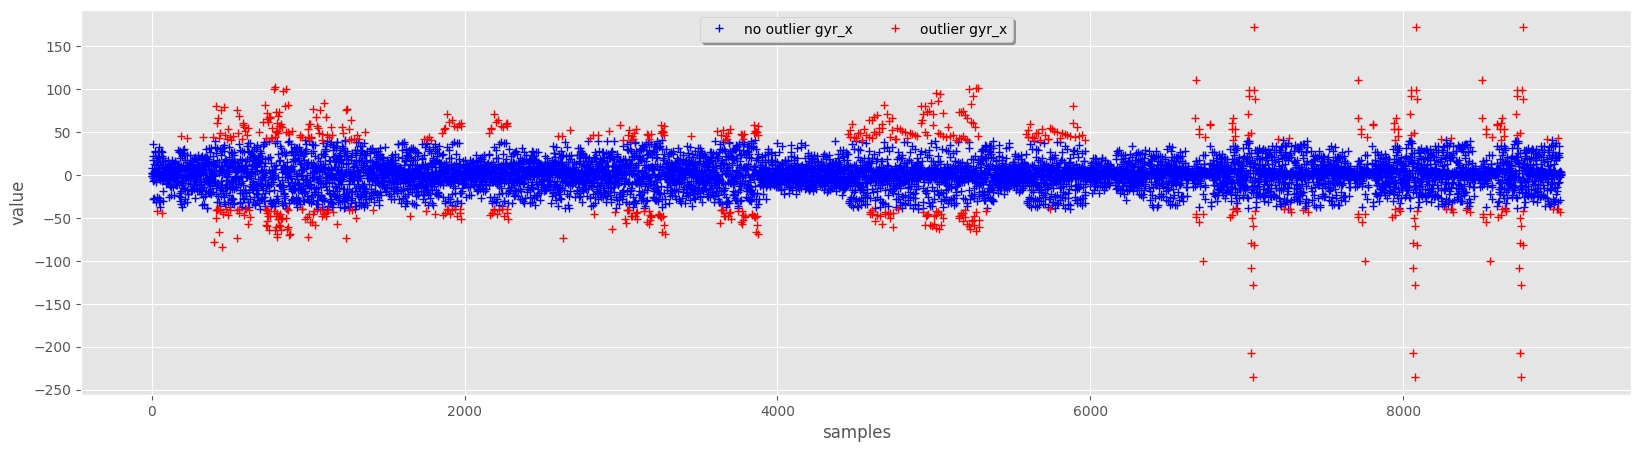

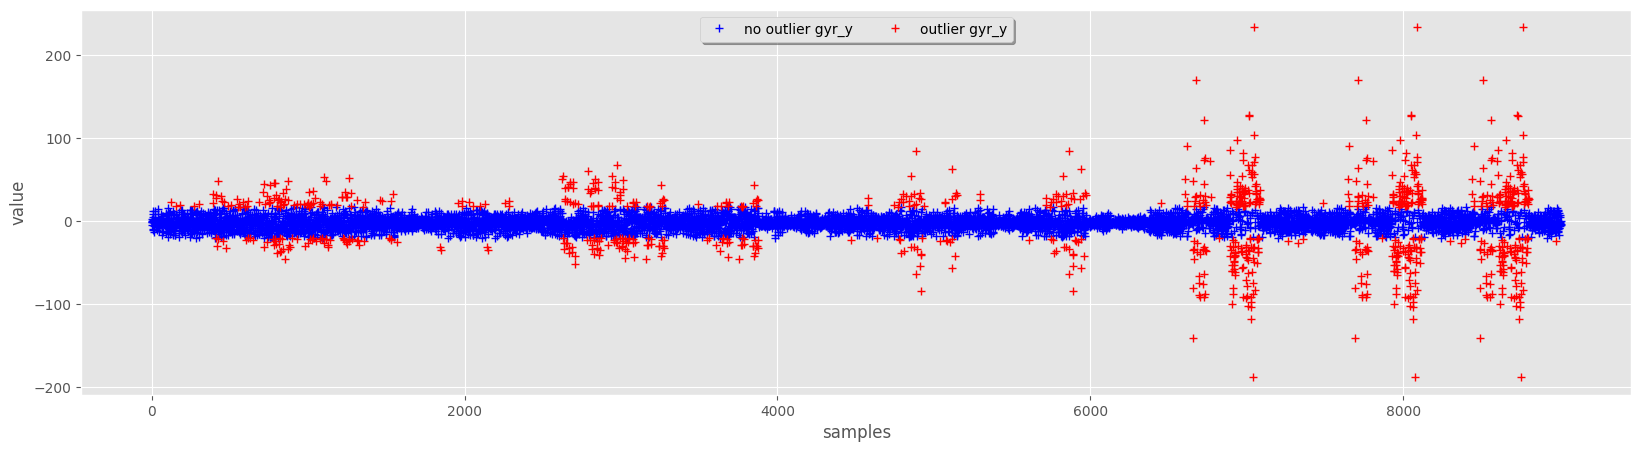

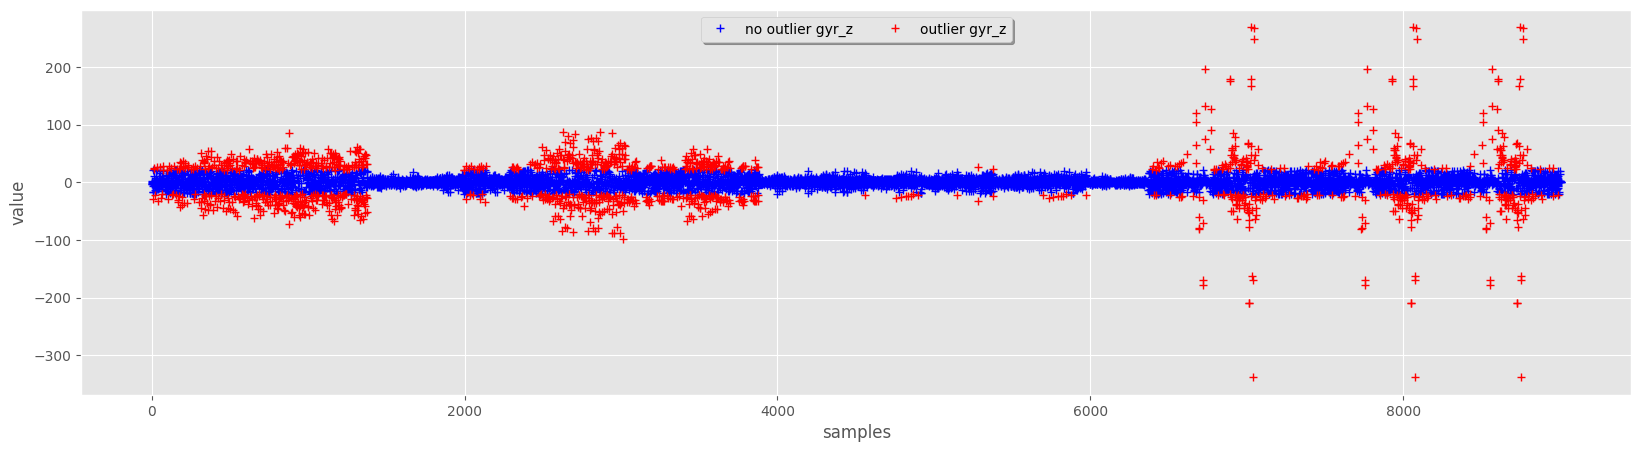

In [14]:
for col in outlier_columns:
    dataset = mark_outliers_iqr(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

array([[<AxesSubplot: title={'center': 'bench'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'dead'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<AxesSubplot: title={'center': 'rest'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'row'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'squat'}, ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

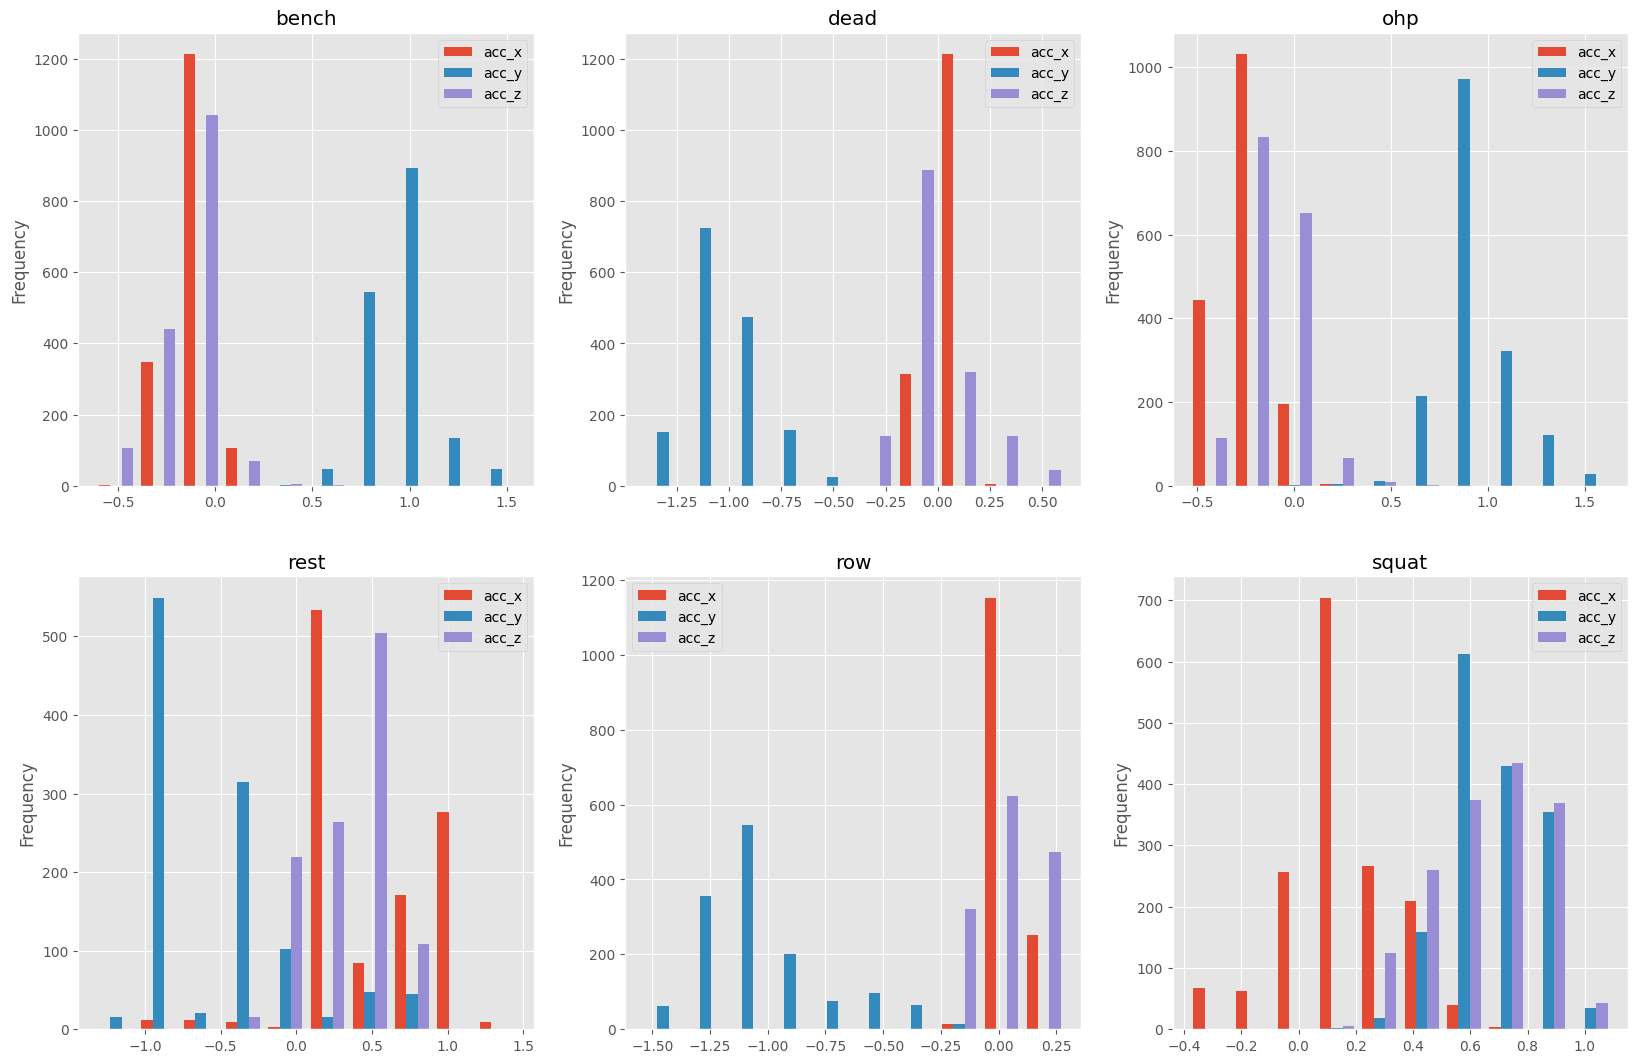

In [19]:
df[outlier_columns[:3] + ["label"]].plot.hist(by="label", figsize=(20, 20), layout=(3,3))

array([[<AxesSubplot: title={'center': 'bench'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'dead'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'ohp'}, ylabel='Frequency'>],
       [<AxesSubplot: title={'center': 'rest'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'row'}, ylabel='Frequency'>,
        <AxesSubplot: title={'center': 'squat'}, ylabel='Frequency'>],
       [<AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>,
        <AxesSubplot: ylabel='Frequency'>]], dtype=object)

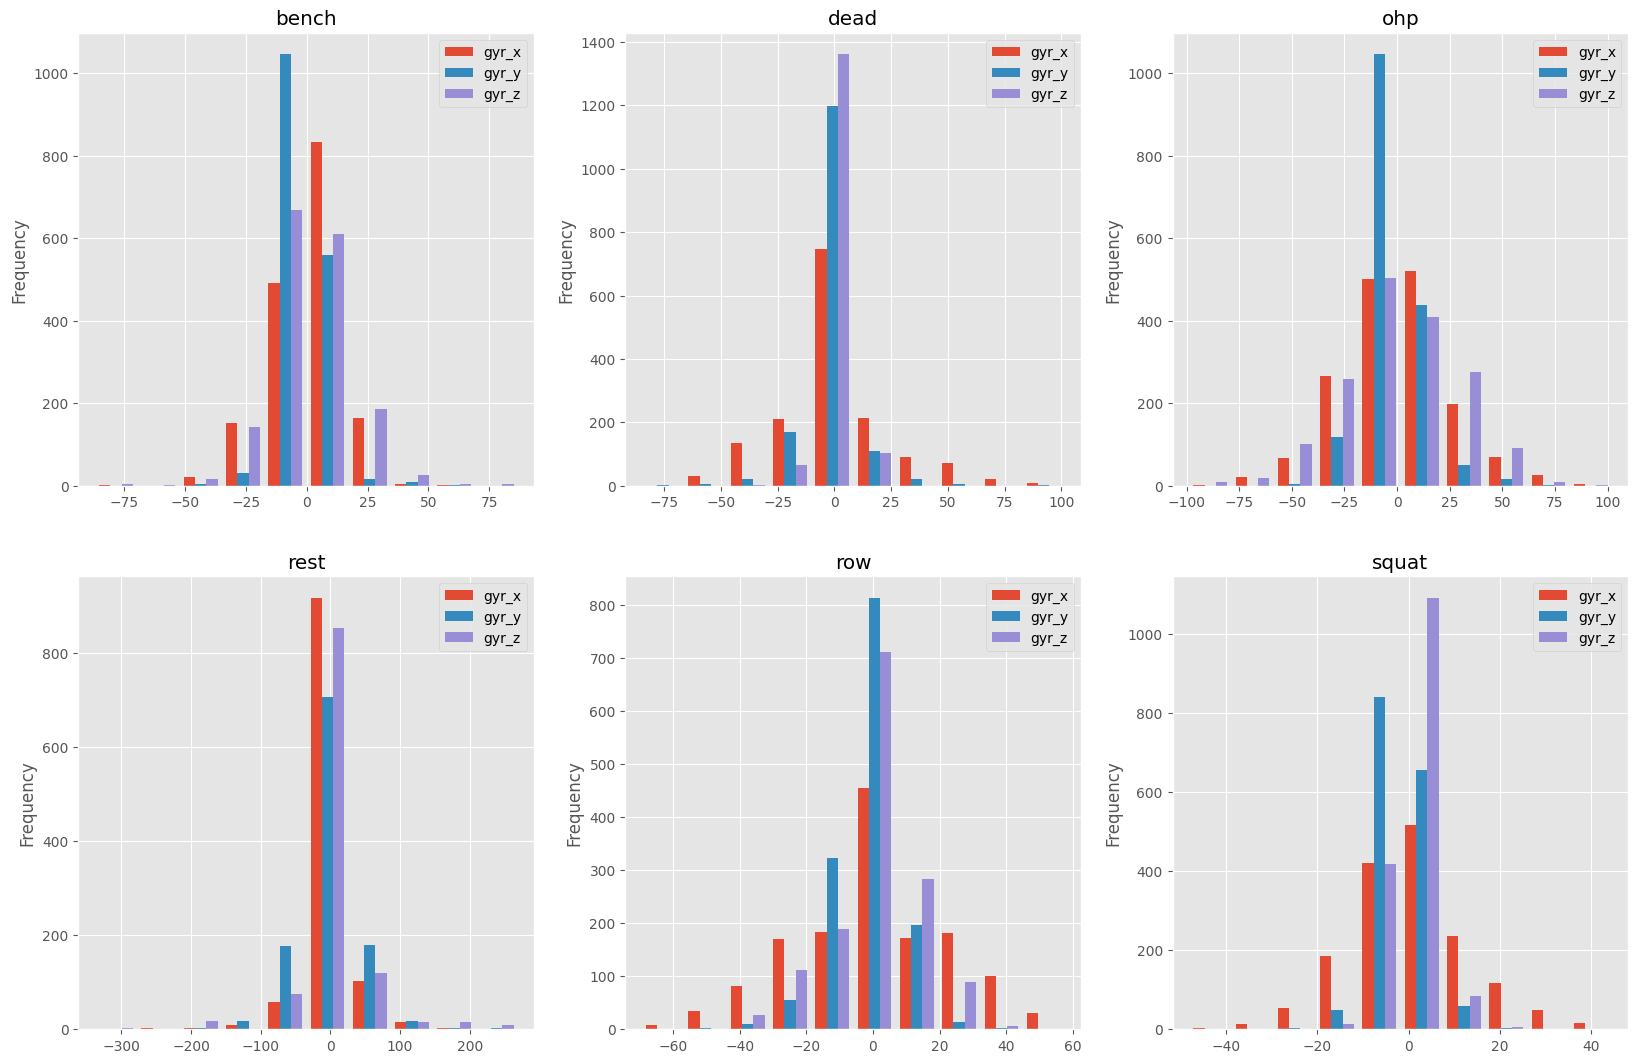

In [20]:
df[outlier_columns[3:] + ["label"]].plot.hist(by="label", figsize=(20, 20), layout=(3,3))

In [21]:
def mark_outliers_chauvenet(dataset, col, C=2):
    """Finds outliers in the specified column of datatable and adds a binary column with
    the same name extended with '_outlier' that expresses the result per data point.
    
    Taken from: https://github.com/mhoogen/ML4QS/blob/master/Python3Code/Chapter3/OutlierDetection.py

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        C (int, optional): Degree of certainty for the identification of outliers given the assumption 
                           of a normal distribution, typicaly between 1 - 10. Defaults to 2.

    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column 
        indicating whether the value is an outlier or not.
    """

    dataset = dataset.copy()
    # Compute the mean and standard deviation.
    mean = dataset[col].mean()
    std = dataset[col].std()
    N = len(dataset.index)
    criterion = 1.0 / (C * N)

    # Consider the deviation for the data points.
    deviation = abs(dataset[col] - mean) / std

    # Express the upper and lower bounds.
    low = -deviation / math.sqrt(C)
    high = deviation / math.sqrt(C)
    prob = []
    mask = []

    # Pass all rows in the dataset.
    for i in range(0, len(dataset.index)):
        # Determine the probability of observing the point
        prob.append(
            1.0 - 0.5 * (scipy.special.erf(high[i]) - scipy.special.erf(low[i]))
        )
        # And mark as an outlier when the probability is below our criterion.
        mask.append(prob[i] < criterion)
    dataset[col + "_outlier"] = mask
    return dataset

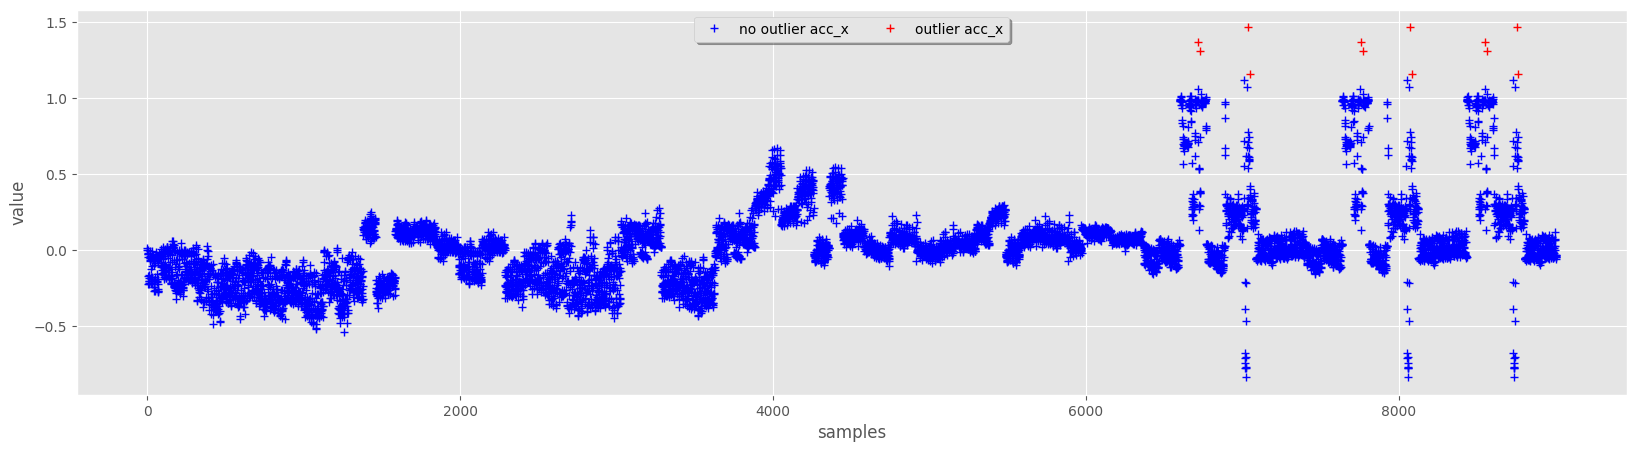

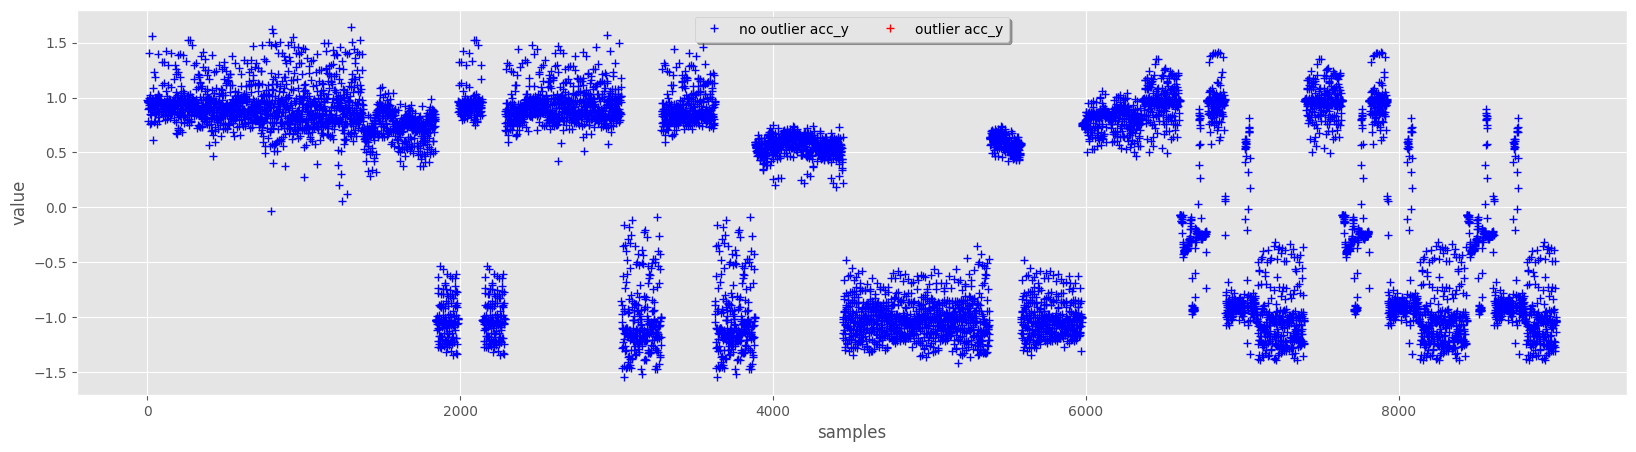

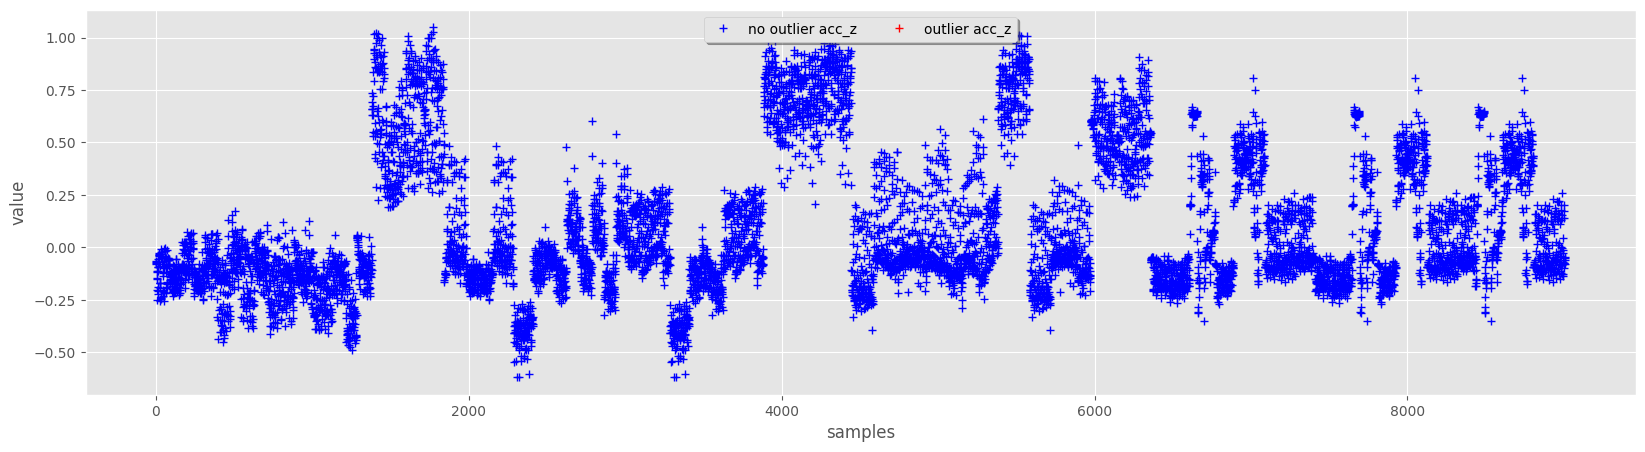

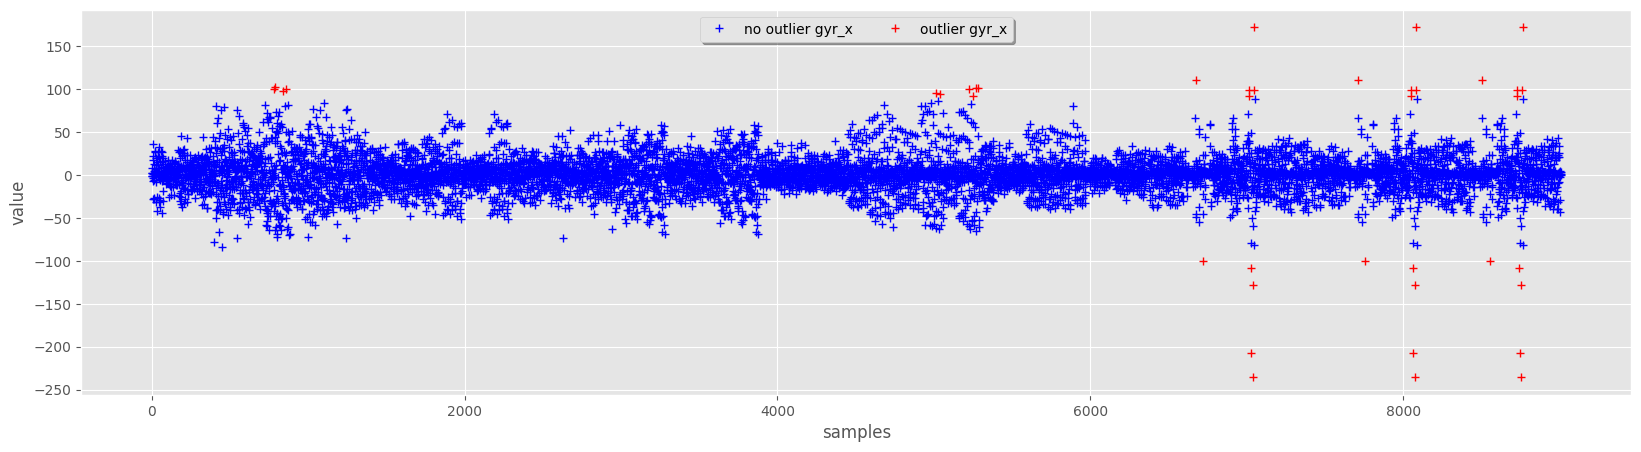

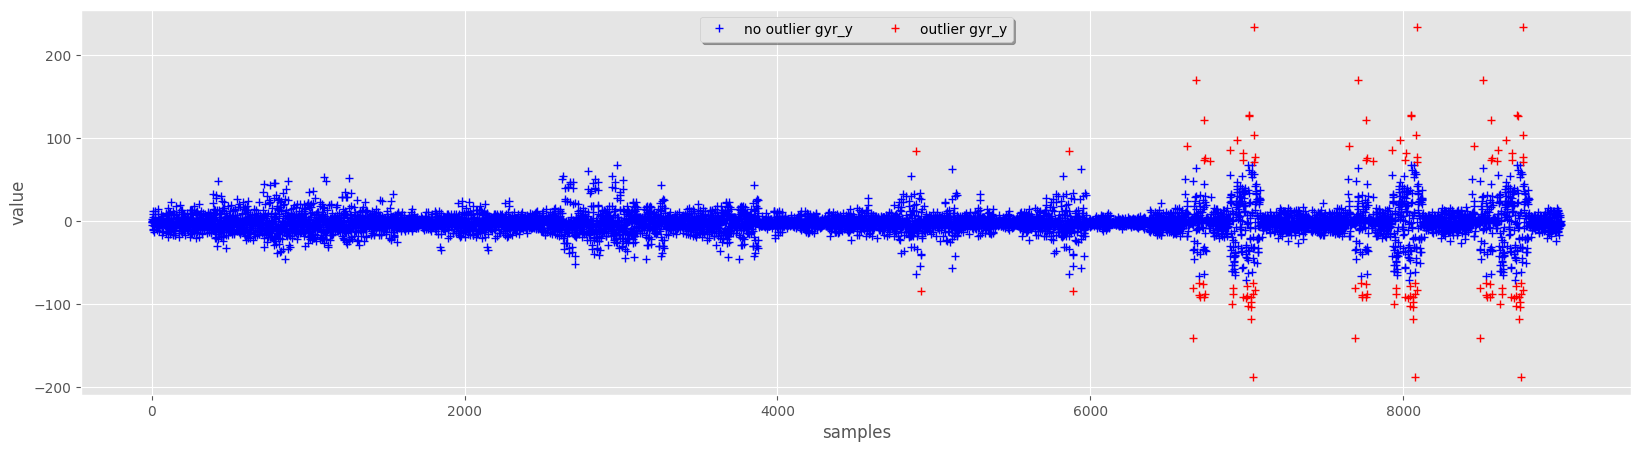

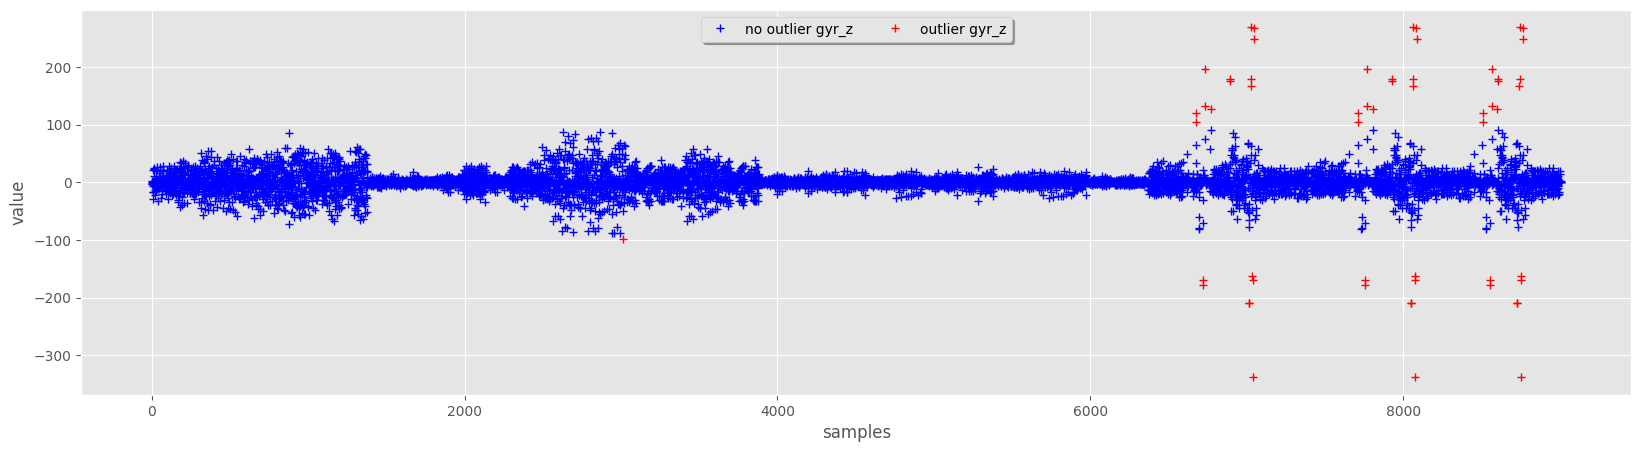

In [22]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df, col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

In [23]:
def mark_outliers_lof(dataset, columns, n=20):
    """Mark values as outliers using LOF

    Args:
        dataset (pd.DataFrame): The dataset
        col (string): The column you want apply outlier detection to
        n (int, optional): n_neighbors. Defaults to 20.
    
    Returns:
        pd.DataFrame: The original dataframe with an extra boolean column
        indicating whether the value is an outlier or not.
    """
    
    dataset = dataset.copy()

    lof = LocalOutlierFactor(n_neighbors=n)
    data = dataset[columns]
    outliers = lof.fit_predict(data)
    X_scores = lof.negative_outlier_factor_

    dataset["outlier_lof"] = outliers == -1
    return dataset, outliers, X_scores

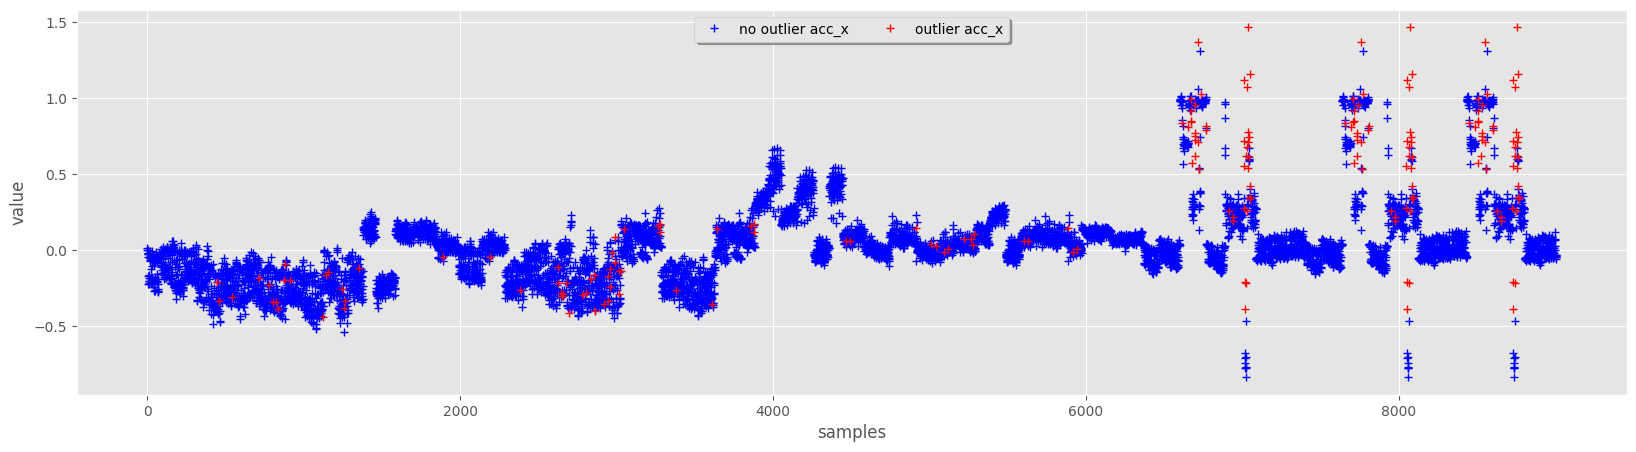

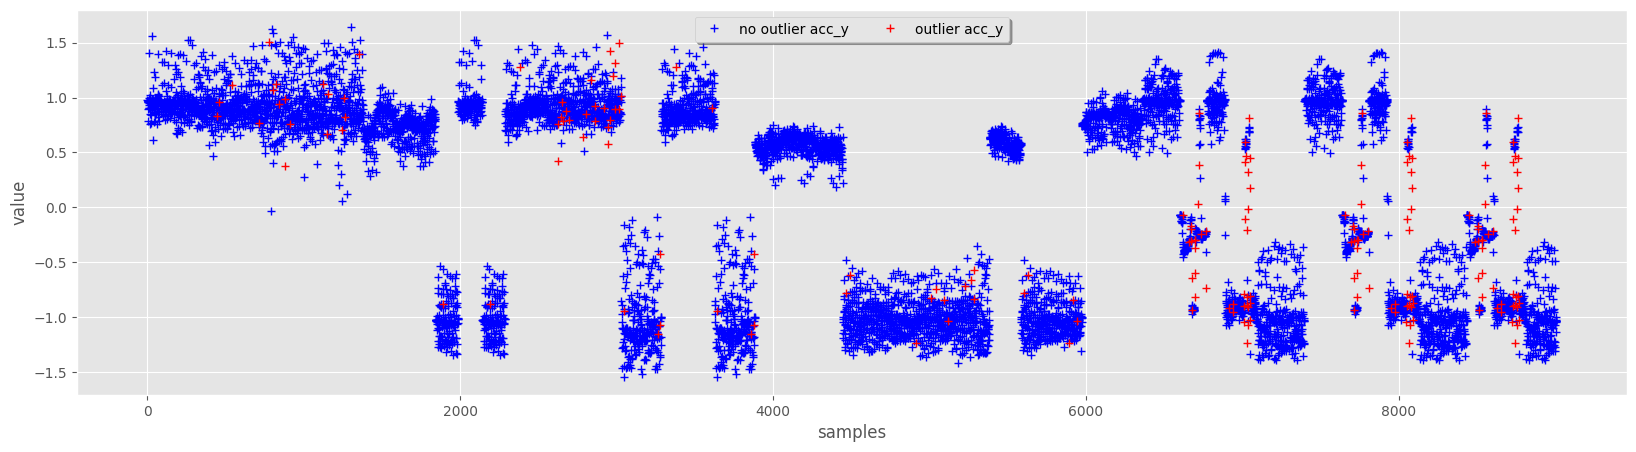

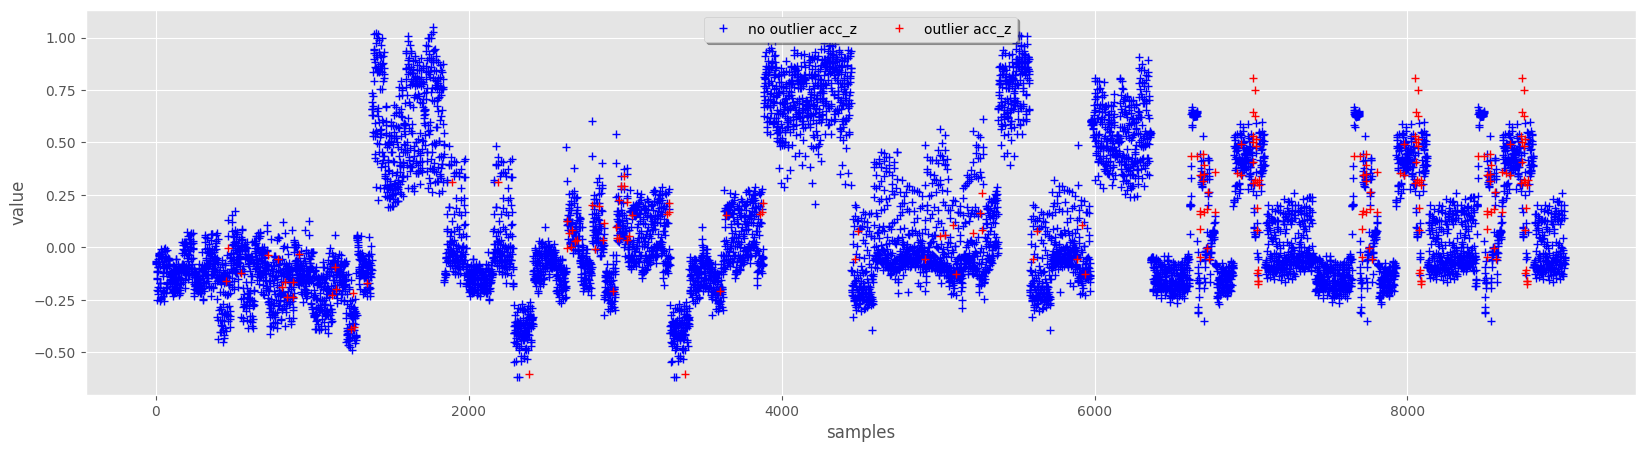

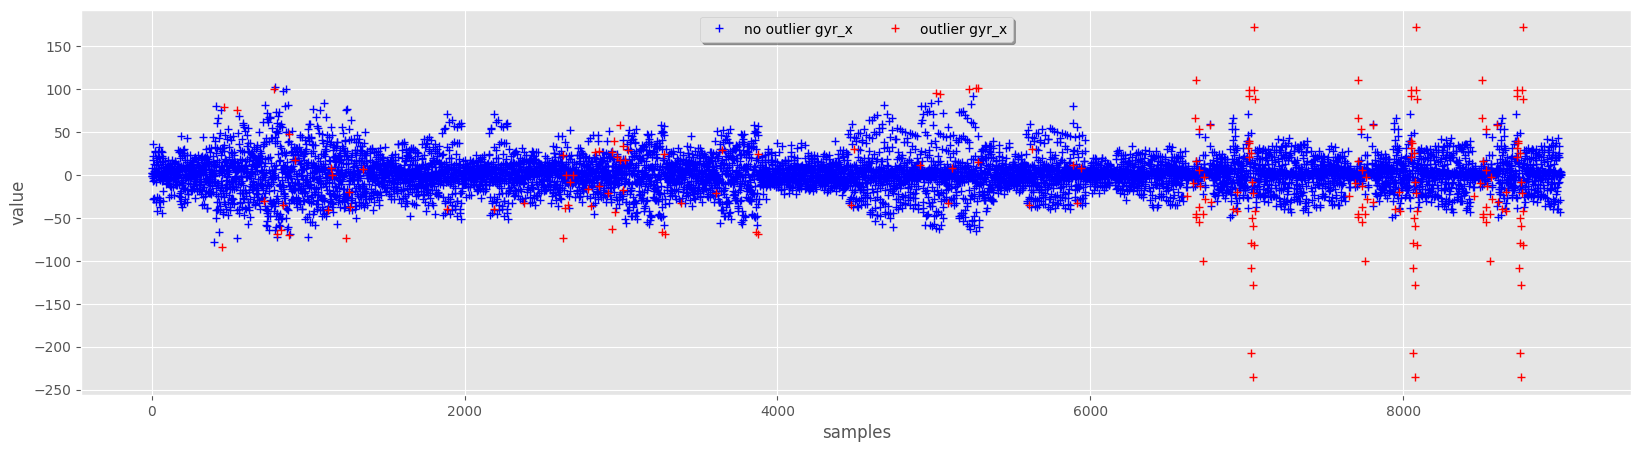

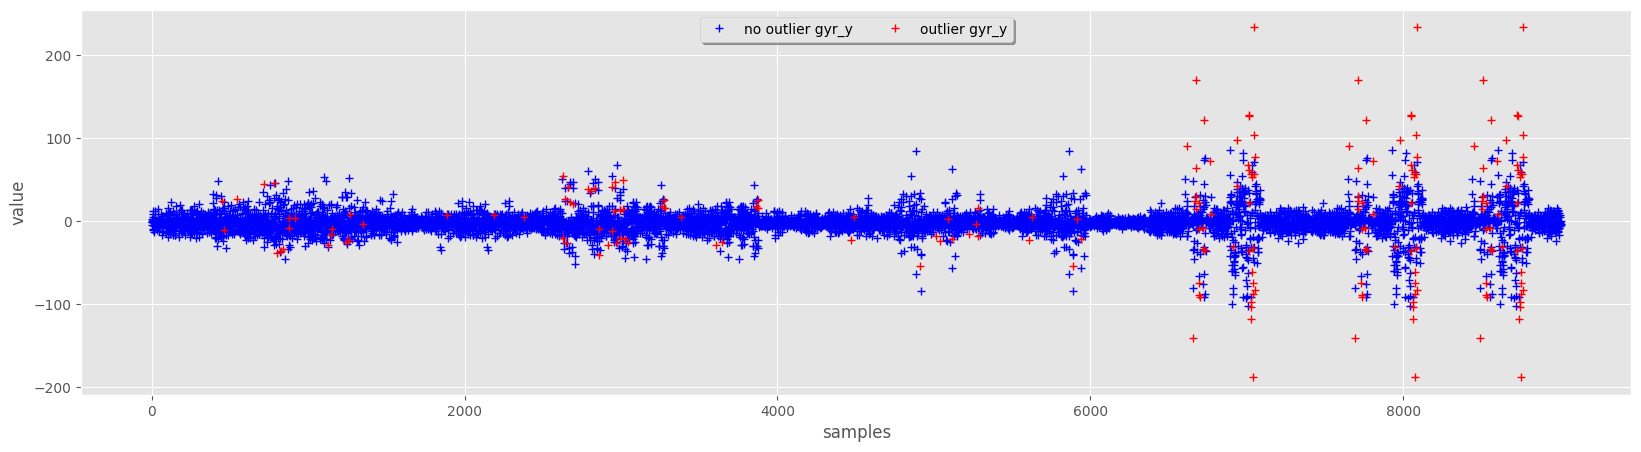

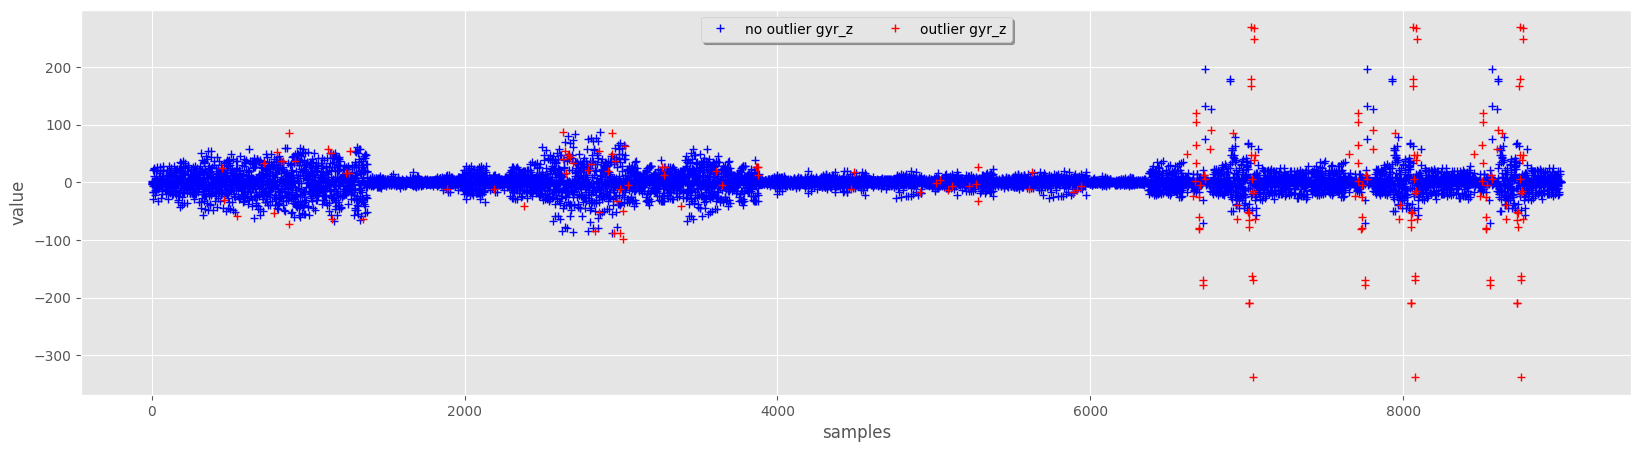

In [24]:
dataset, outliers, X_scores = mark_outliers_lof(df, outlier_columns) #we dont loop throu this fn.directly giving outlier col as i/p
for col in outlier_columns:
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True)

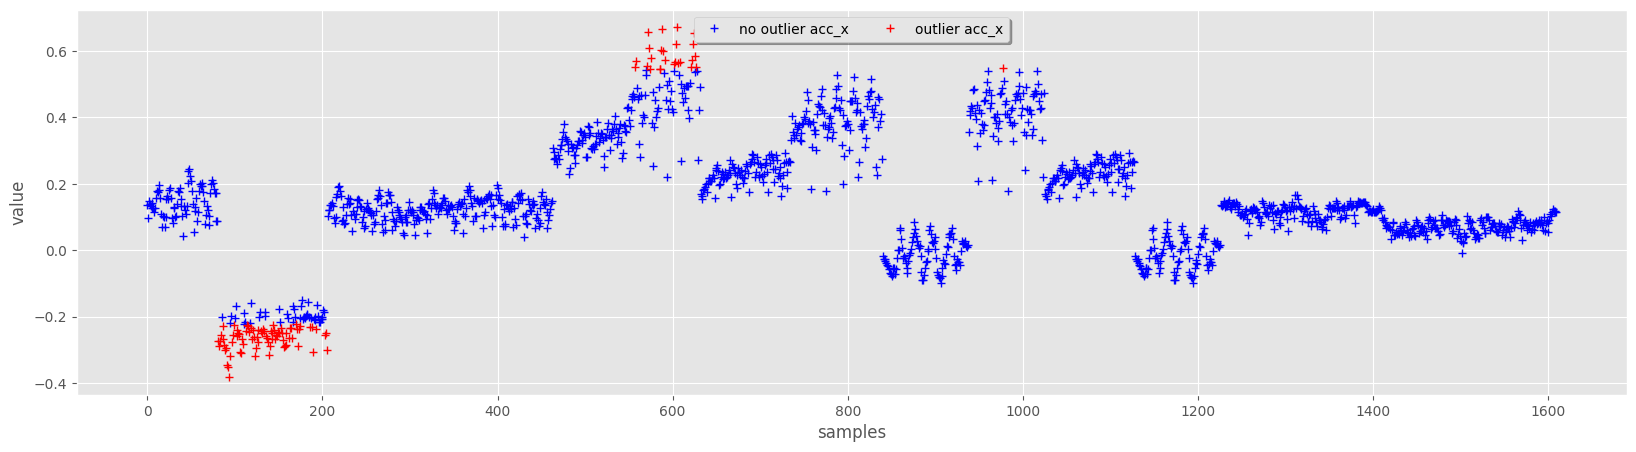

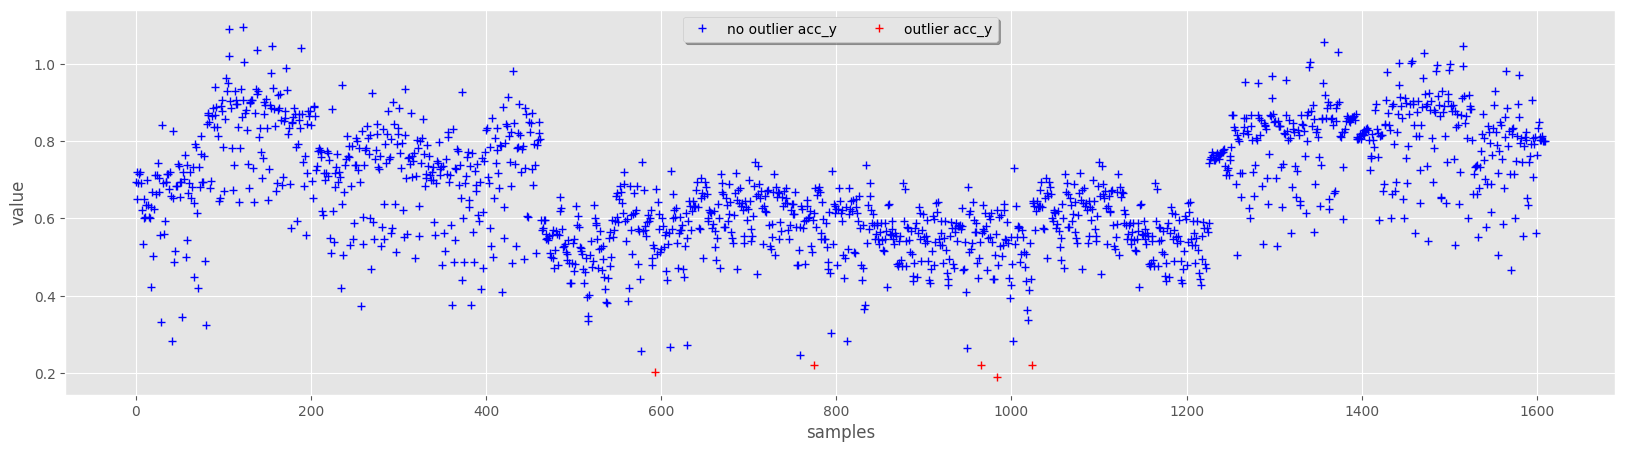

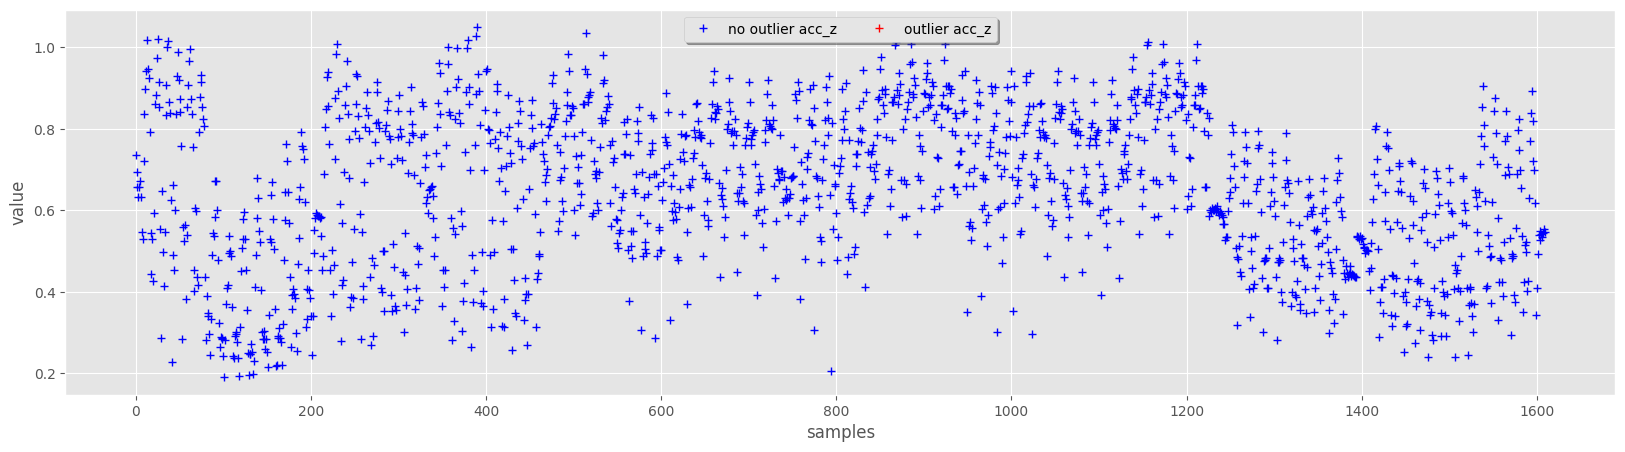

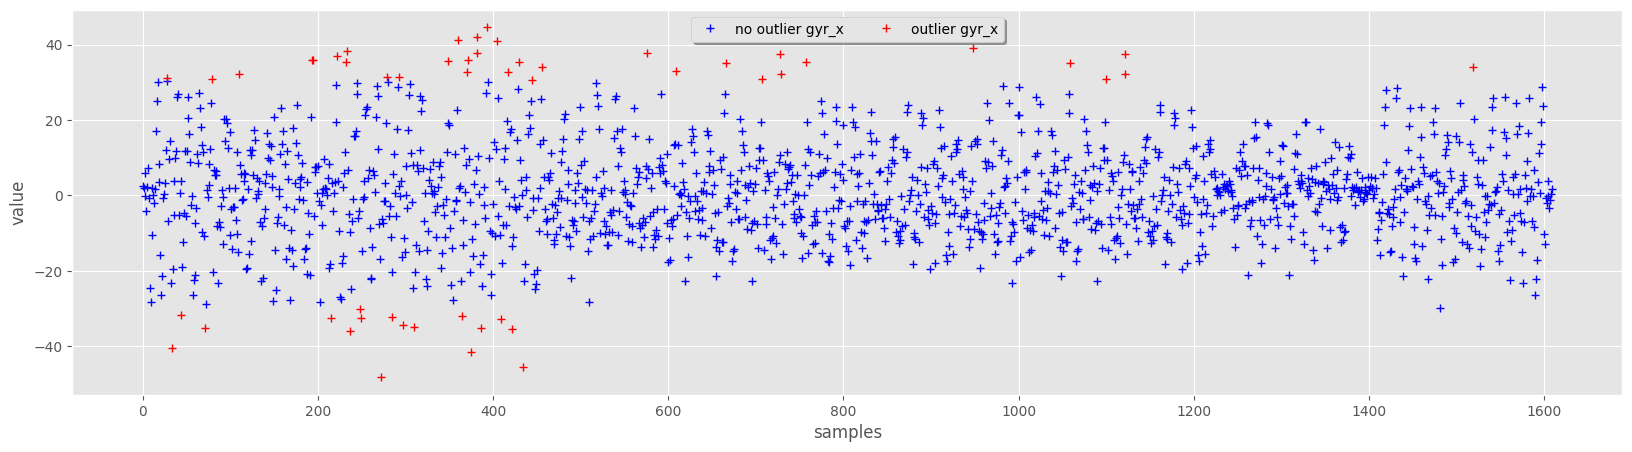

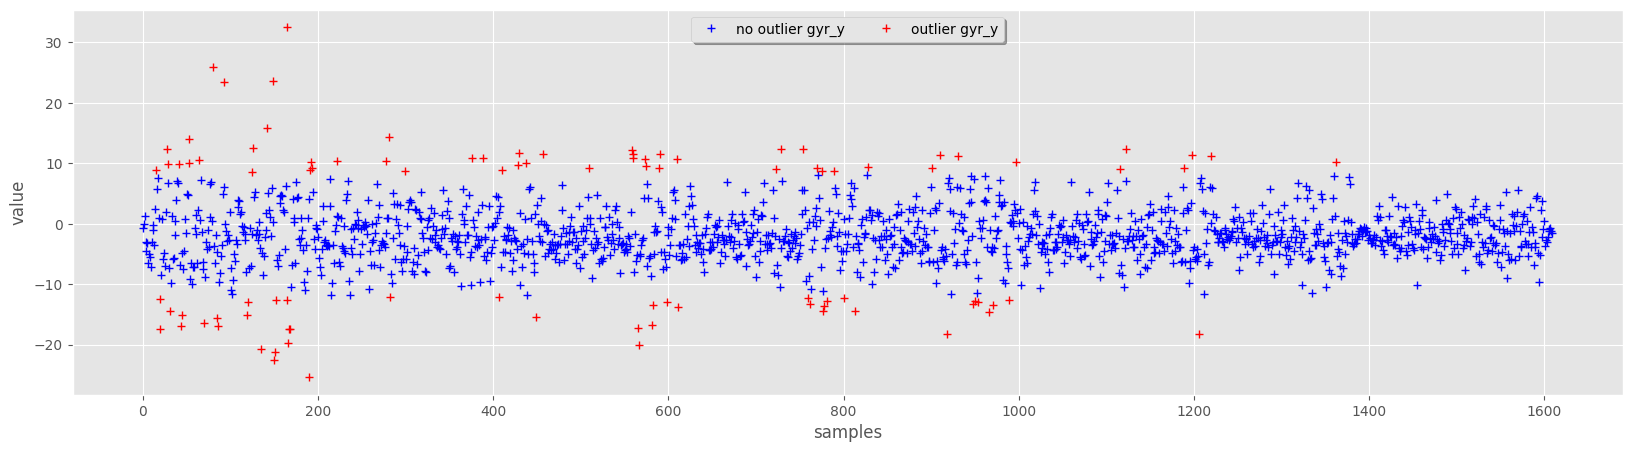

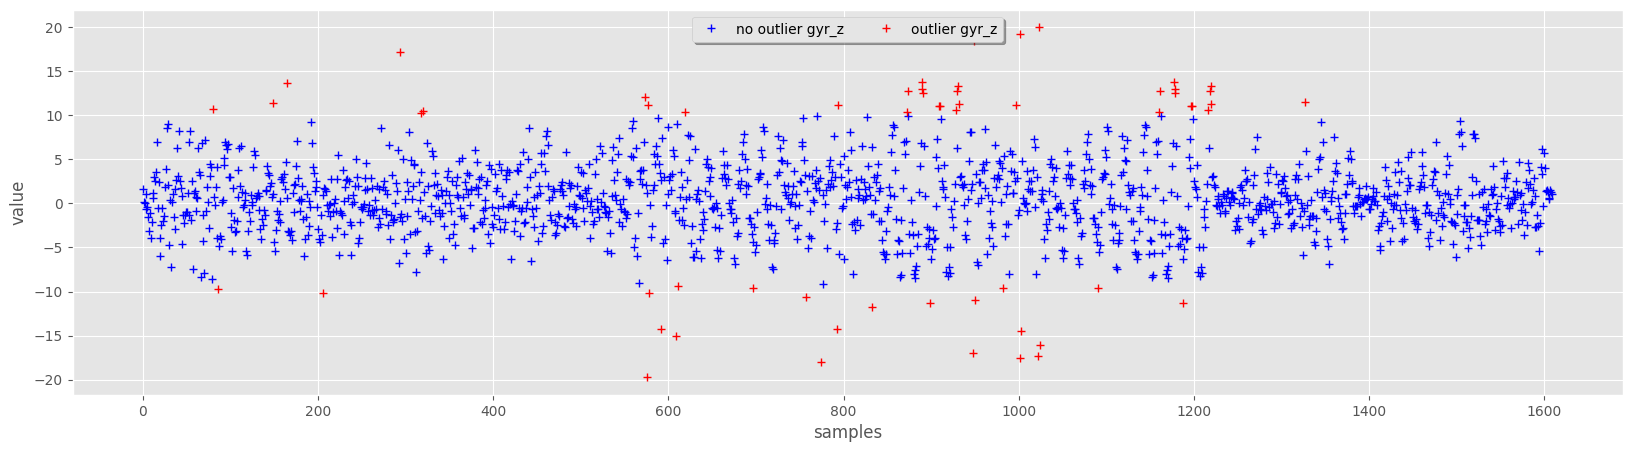

In [25]:
label = "squat"
for col in outlier_columns:
    dataset = mark_outliers_iqr(df[df['label']==label], col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

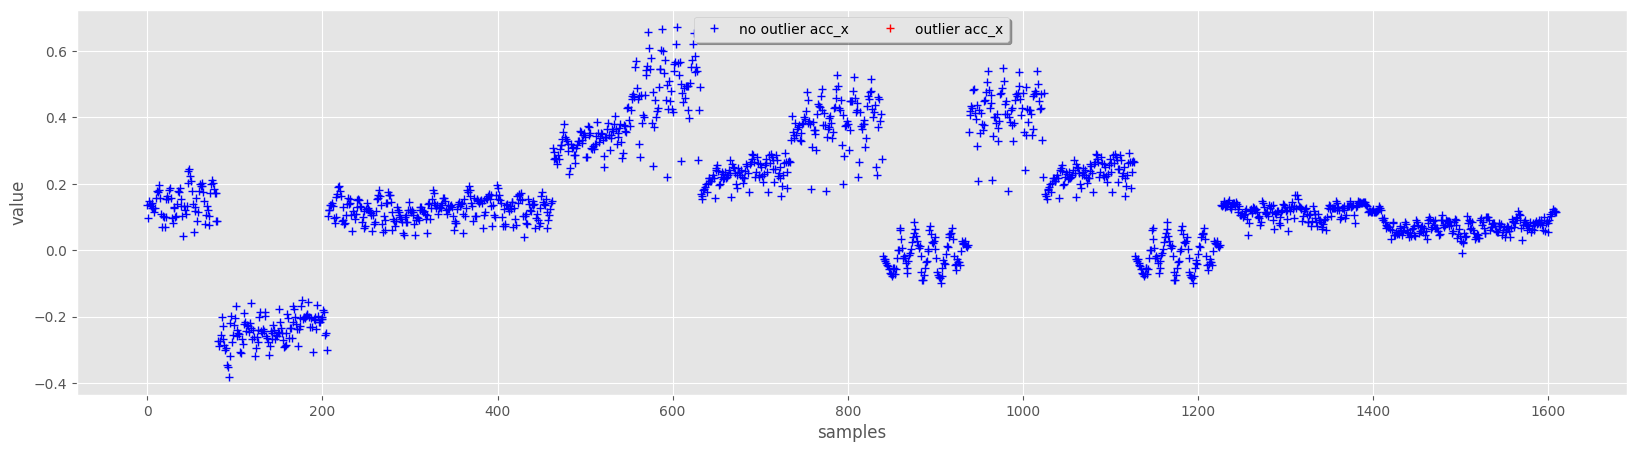

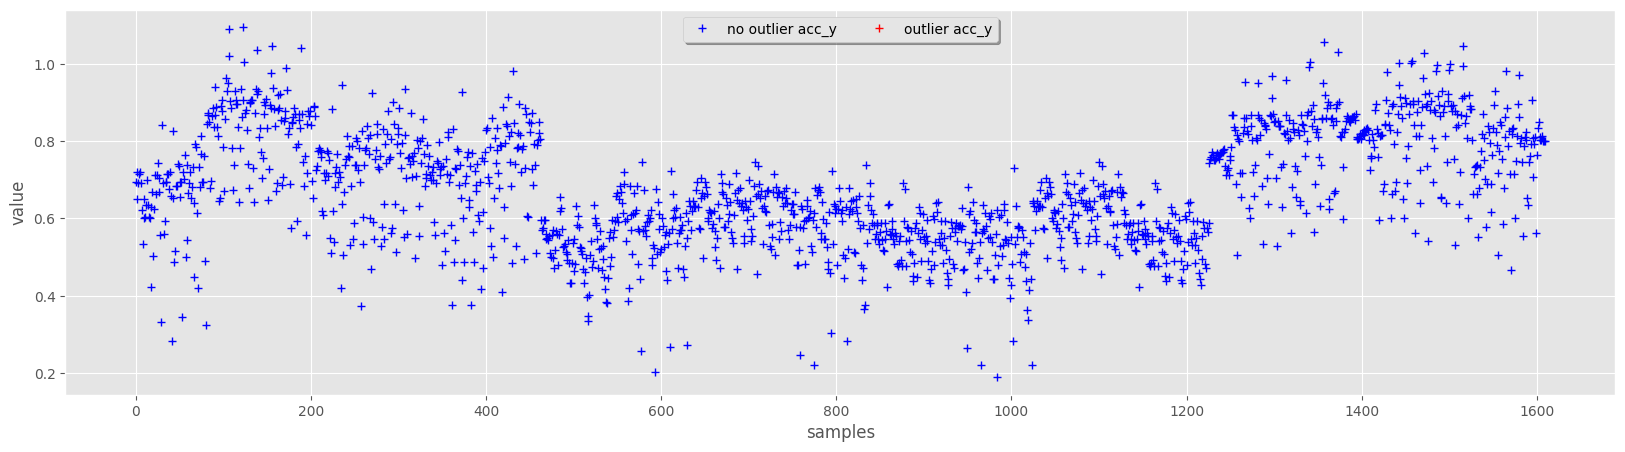

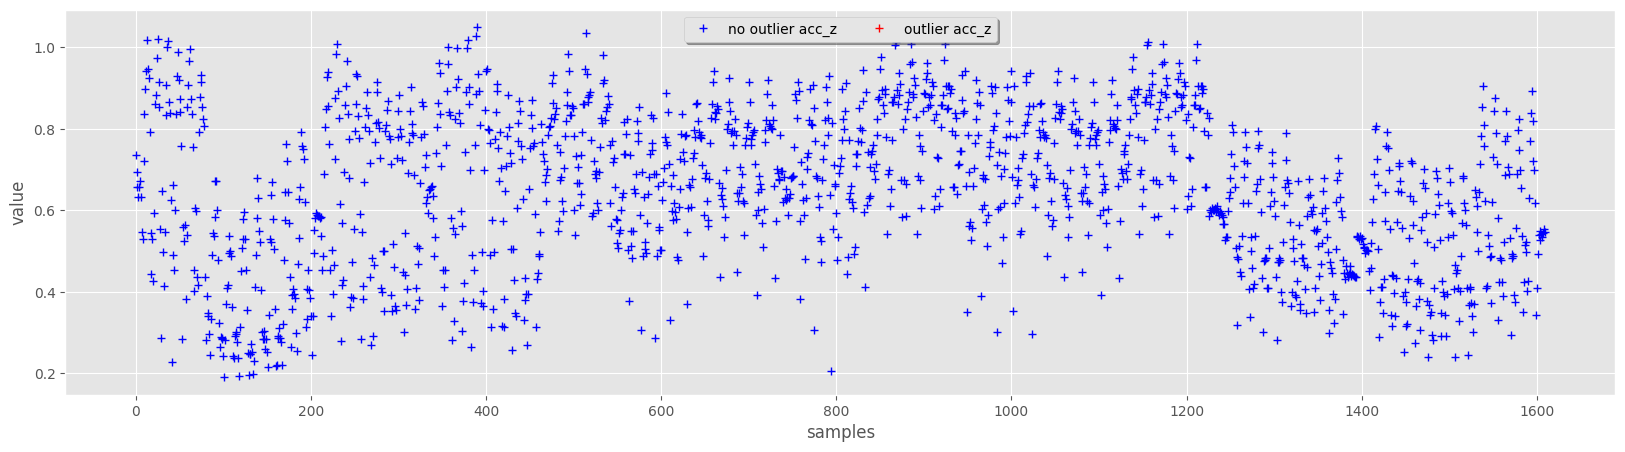

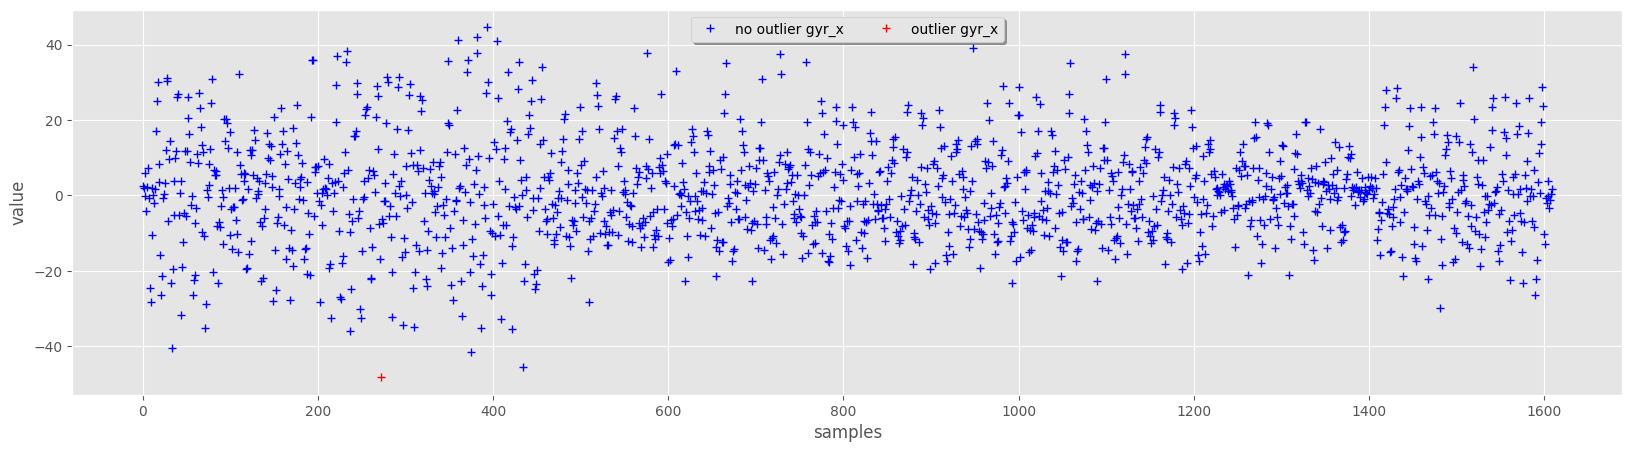

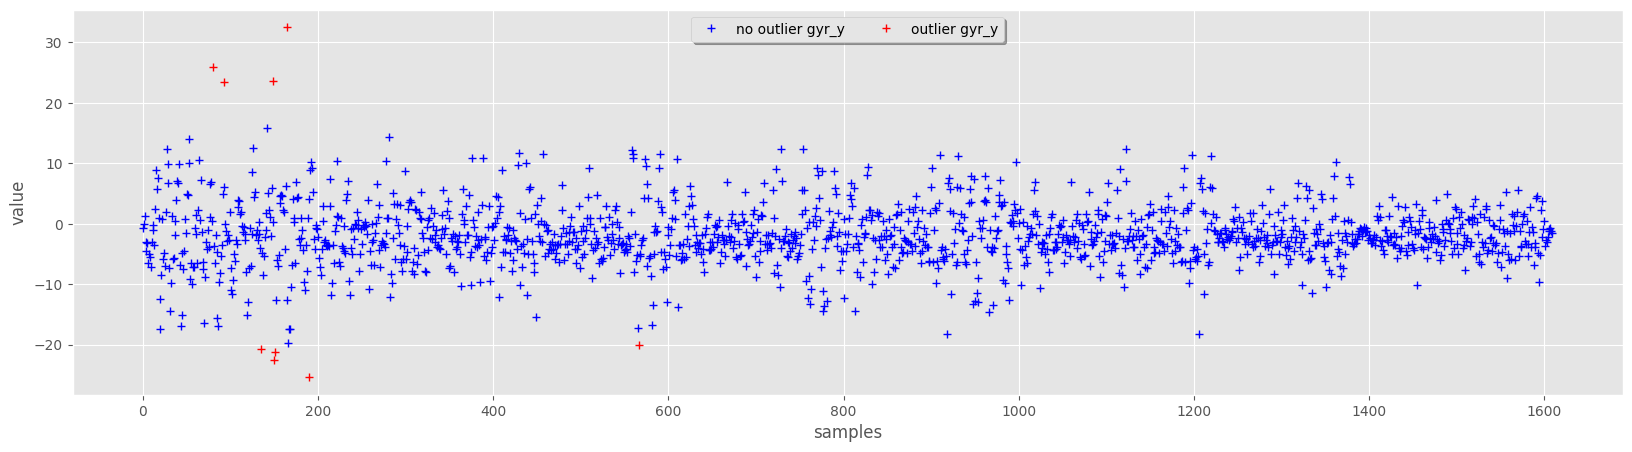

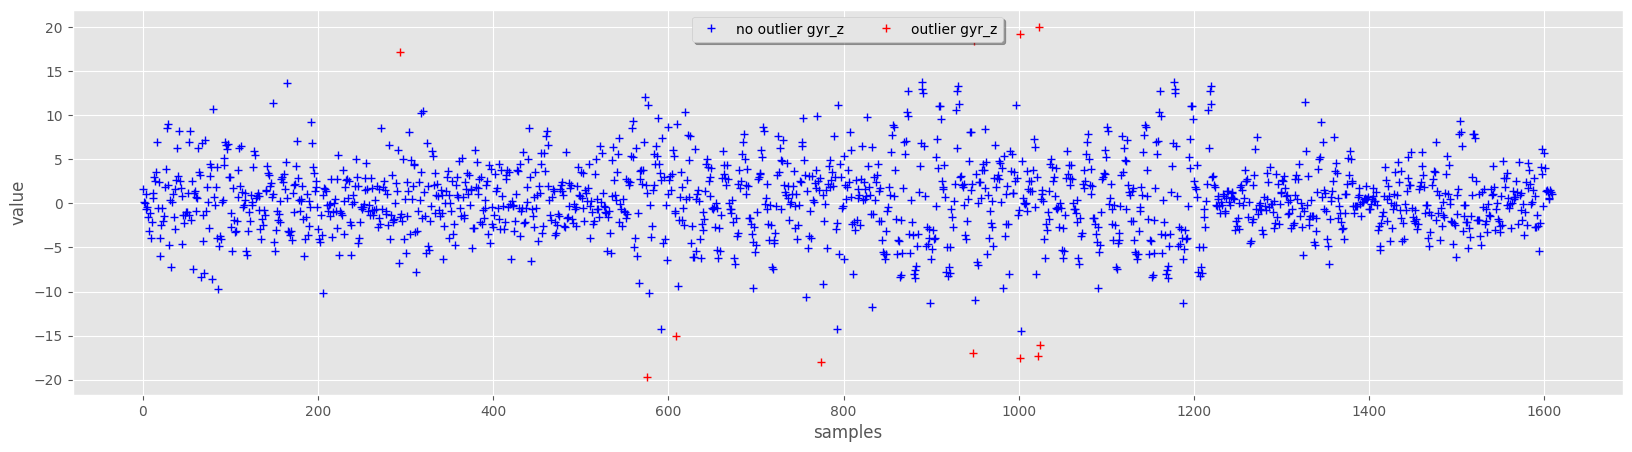

In [26]:
for col in outlier_columns:
    dataset = mark_outliers_chauvenet(df[df['label']==label], col)
    plot_binary_outliers(dataset=dataset, col=col, outlier_col=col+"_outlier", reset_index=True)

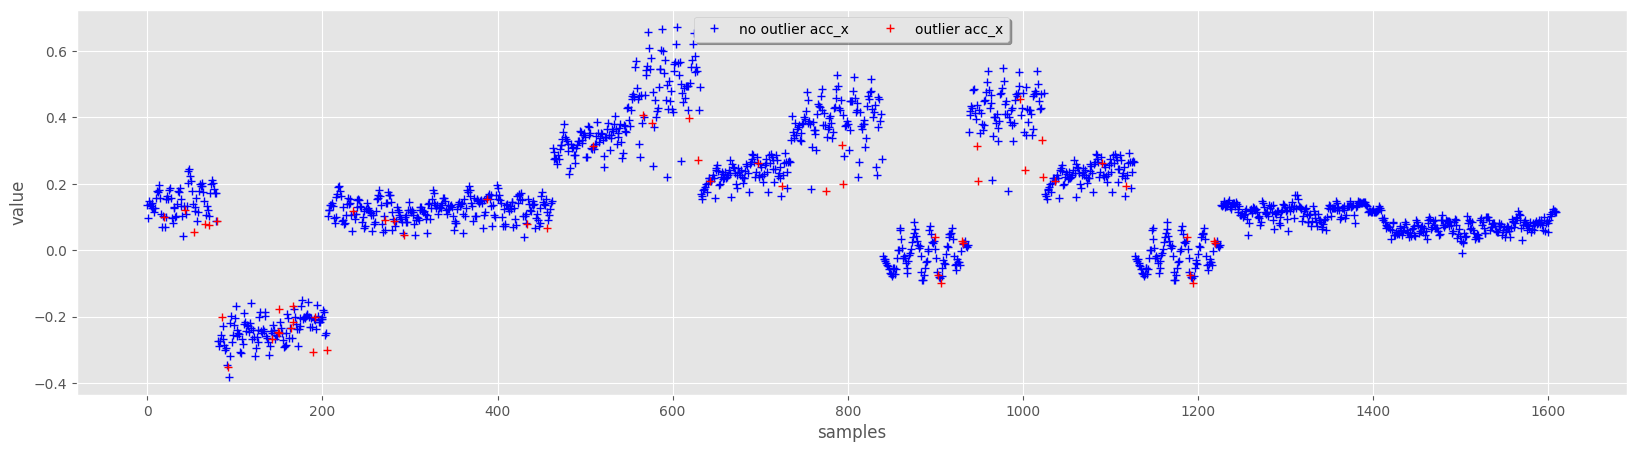

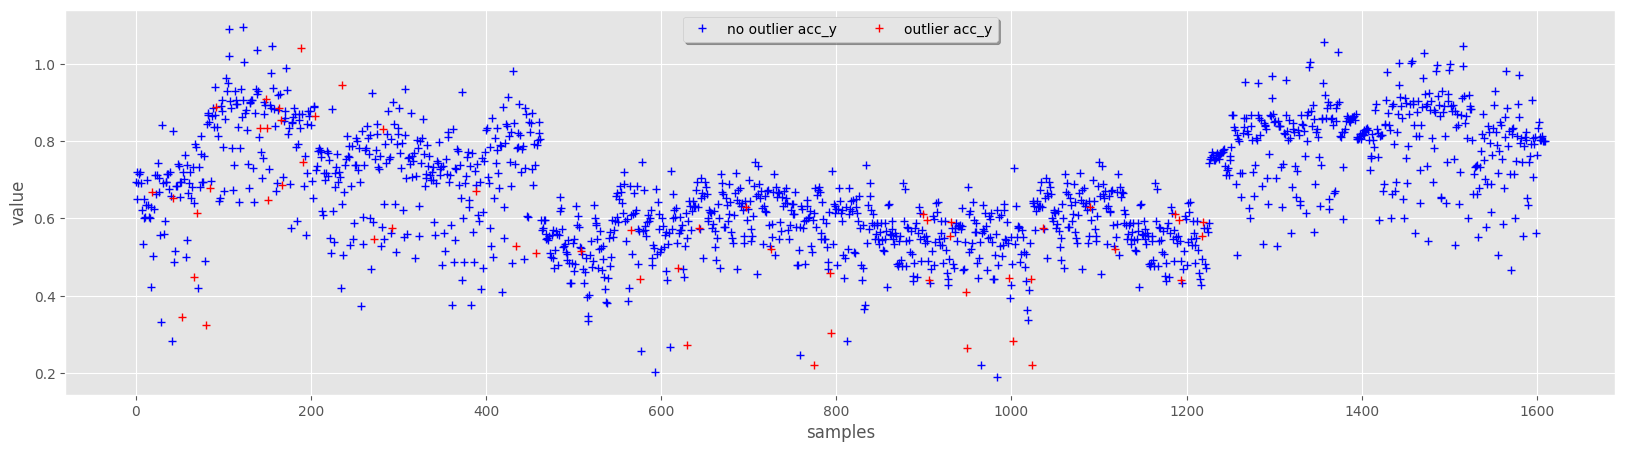

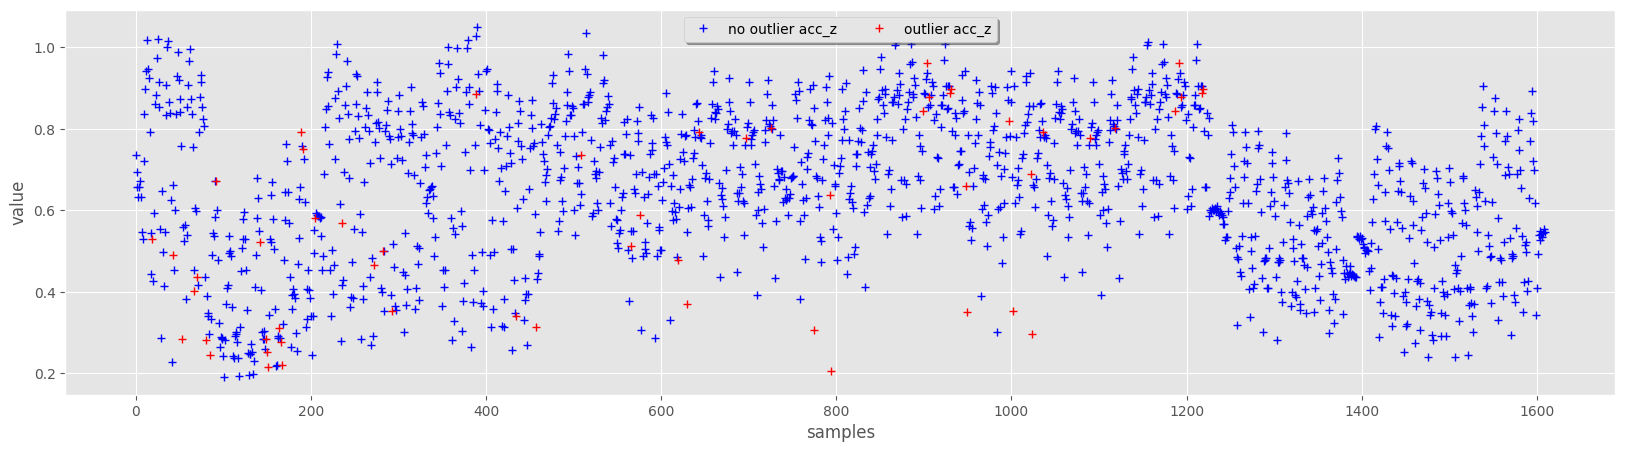

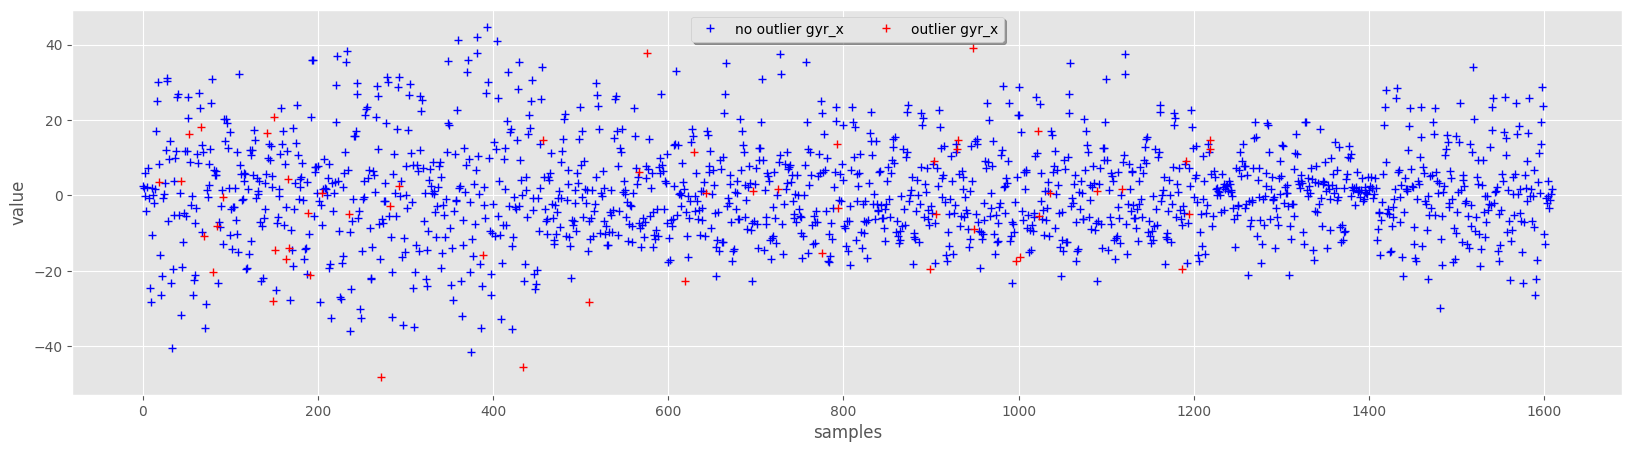

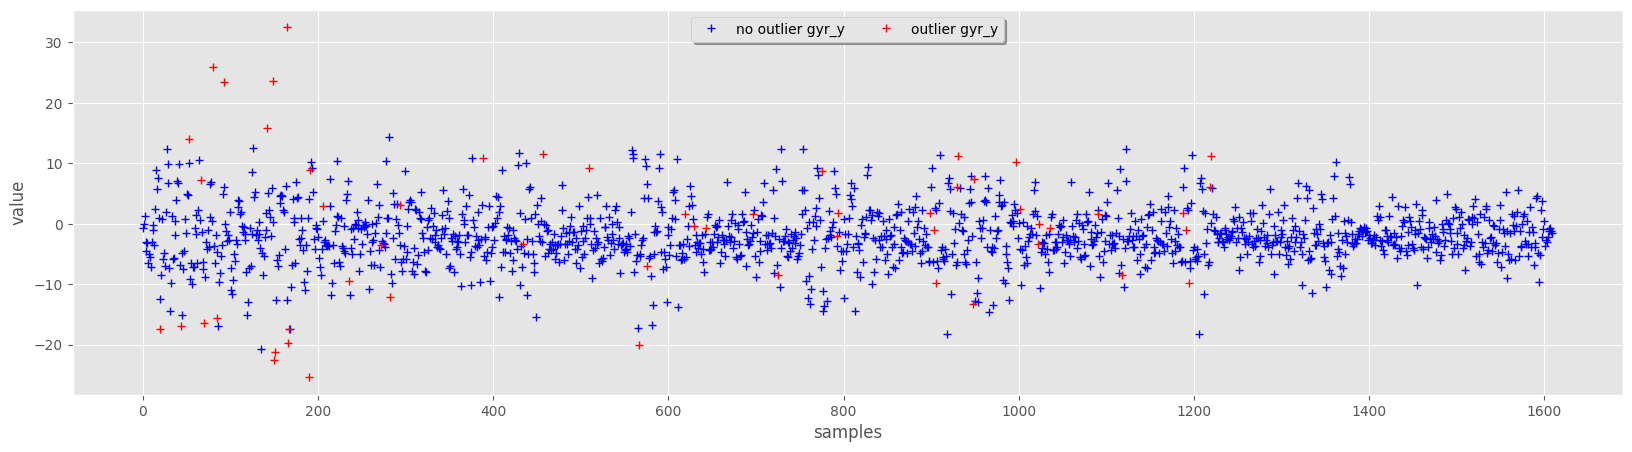

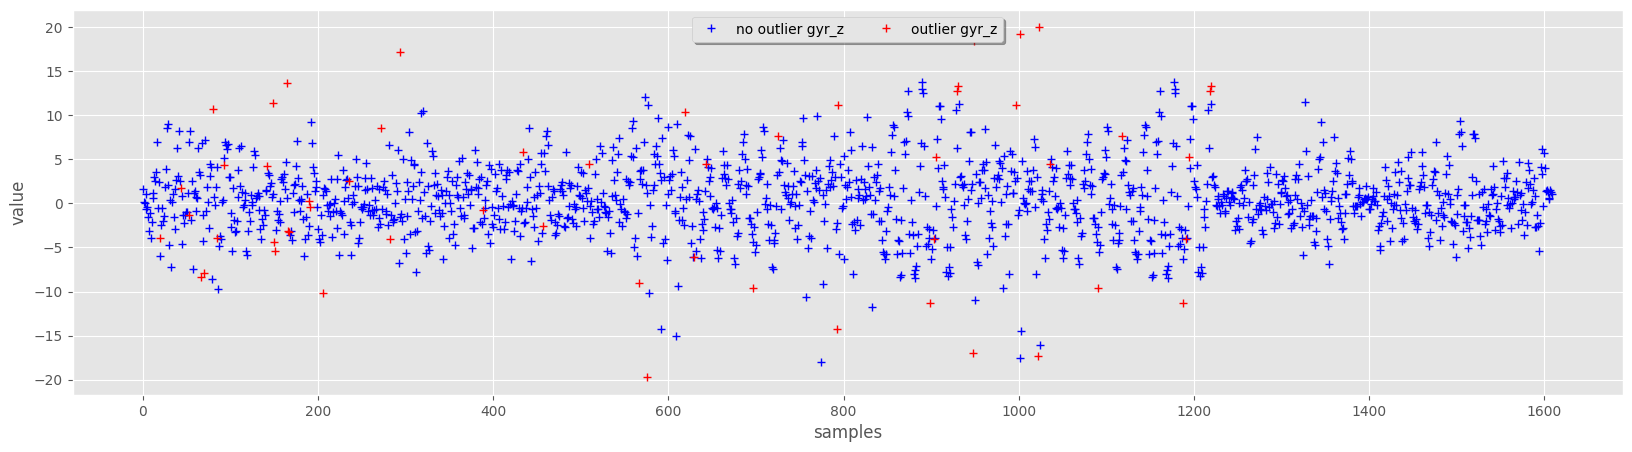

In [27]:
dataset, outliers, X_scores = mark_outliers_lof(df[df['label']==label], outlier_columns) #we dont loop throu this fn.directly giving outlier col as i/p
for col in outlier_columns:
    plot_binary_outliers(dataset=dataset, col=col, outlier_col="outlier_lof", reset_index=True)

In [28]:
col = "gyr_z"
dataset = mark_outliers_chauvenet(df, col)
dataset[dataset['gyr_z_outlier']]

dataset.loc[dataset['gyr_z_outlier'],"gyr_z"] =np.nan

In [29]:
outliers_removed_df = df.copy()
for col in outlier_columns:
    for label in df['label'].unique():
        dataset = mark_outliers_chauvenet(df[df['label']==label], col)

        #Repalce values marked as outliers with Nan
        dataset.loc[dataset[col+"_outlier"],col] =np.nan
        
        #Update the column in the original dataframe
        outliers_removed_df.loc[(outliers_removed_df['label']==label),col] = dataset[col]
        
        n_outliers = len(dataset)-len(dataset[col].dropna())
        print(f"Removed {n_outliers} from {col} for {label}")

Removed 0 from acc_x for bench
Removed 2 from acc_x for ohp
Removed 0 from acc_x for squat
Removed 2 from acc_x for dead
Removed 0 from acc_x for row
Removed 0 from acc_x for rest
Removed 5 from acc_y for bench
Removed 6 from acc_y for ohp
Removed 0 from acc_y for squat
Removed 0 from acc_y for dead
Removed 0 from acc_y for row
Removed 0 from acc_y for rest
Removed 3 from acc_z for bench
Removed 6 from acc_z for ohp
Removed 0 from acc_z for squat
Removed 1 from acc_z for dead
Removed 0 from acc_z for row
Removed 0 from acc_z for rest
Removed 2 from gyr_x for bench
Removed 4 from gyr_x for ohp
Removed 1 from gyr_x for squat
Removed 6 from gyr_x for dead
Removed 0 from gyr_x for row
Removed 12 from gyr_x for rest
Removed 14 from gyr_y for bench
Removed 15 from gyr_y for ohp
Removed 9 from gyr_y for squat
Removed 14 from gyr_y for dead
Removed 10 from gyr_y for row
Removed 9 from gyr_y for rest
Removed 13 from gyr_z for bench
Removed 1 from gyr_z for ohp
Removed 12 from gyr_z for squat
Re

In [30]:
outliers_removed_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9009 entries, 2019-01-11 15:08:05.200000 to 2019-01-20 17:33:27.800000
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   acc_x        9005 non-null   float64
 1   acc_y        8998 non-null   float64
 2   acc_z        8999 non-null   float64
 3   gyr_x        8984 non-null   float64
 4   gyr_y        8938 non-null   float64
 5   gyr_z        8945 non-null   float64
 6   participant  9009 non-null   object 
 7   label        9009 non-null   object 
 8   category     9009 non-null   object 
 9   set          9009 non-null   int32  
dtypes: float64(6), int32(1), object(3)
memory usage: 739.0+ KB


In [31]:
outliers_removed_df.to_pickle("../../data/interim/02_outliers_removed_chauvenets.pkl")